# [IAPR 2019:][iapr2019] Special project

**Group members:**
1- Zhou Xiao ,
2- Lorenzo Berardo ,
3- Wu Yi-Shiun

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

In [1]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv2
import matplotlib.mlab
from collections import defaultdict
from functools import reduce
from skimage import measure,io
from scipy.optimize import curve_fit
from scipy.signal import medfilt
from scipy.stats import norm
import os
import warnings
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import scipy
from scipy import ndimage, misc, signal
from functools import reduce
import xml.etree.ElementTree as ET
import pickle
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier
from tempfile import TemporaryFile
warnings.filterwarnings('ignore')

In [2]:
# functions to plot learning curves in part 3
def plot_history(history, loss_name, metric_name,title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel(loss_name)
    ax1.set_xlabel('epoch')
    ax1.set_yscale('log')
    ax2.set_ylabel(metric_name)
    ax2.set_xlabel('epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history[metric_name], label = "training")
    ax2.plot(history.history['val_'+metric_name], label = "validation")
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
def plot_different_histories(history_1, history_2, history_3,history_4, label_1='', label_2='', label_3='',label_4='',title=''):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 7))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel('epoch')
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel('epoch')
    
    ax1.plot(history_1.history['loss'], label=label_1 + ' training',c='r')
    ax1.plot(history_1.history['val_loss'], label=label_1 + ' validation',c='r',linestyle='--')
    ax1.plot(history_2.history['loss'], label=label_2 + ' training',c='g')
    ax1.plot(history_2.history['val_loss'], label=label_2 + ' validation',c='g',linestyle='--')
    ax1.plot(history_3.history['loss'], label=label_3 + ' training',c='b')
    ax1.plot(history_3.history['val_loss'], label=label_3 + ' validation',c='b',linestyle='--')
    ax1.plot(history_4.history['loss'], label=label_3 + ' training',c='brown')
    ax1.plot(history_4.history['val_loss'], label=label_3 + ' validation',c='brown',linestyle='--')
    ax2.plot(history_1.history['acc'], label=label_1 + ' training',c='r')
    ax2.plot(history_1.history['val_acc'], label=label_1 + ' validation',c='r',linestyle='--')
    ax2.plot(history_2.history['acc'], label=label_2 + ' training',c='g')
    ax2.plot(history_2.history['val_acc'], label=label_2 + ' validation',c='g',linestyle='--')
    ax2.plot(history_3.history['acc'], label=label_3 + ' training',c='b')
    ax2.plot(history_3.history['val_acc'], label=label_3 + ' validation',c='b',linestyle='--')
    ax2.plot(history_4.history['acc'], label=label_3 + ' training',c='brown')
    ax2.plot(history_4.history['val_acc'], label=label_3 + ' validation',c='brown',linestyle='--')
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

### Loading Data

In [3]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects



In [4]:
def get_dataset(num,data_type='train'):
    data_dir = 'project-data/'
    with open(data_dir+data_type+'.txt', 'r') as f:
        filenames = f.read().split('\n')
        
    # Get images
    images = skimage.io.imread_collection([data_dir+'images/'+data_type+'/'+img_name+'.jpg'
                                                      for img_name in filenames])
    
    # Get groundtruth
    bboxes = [parse_file(data_dir+'annotations/'+data_type+'/'+img_name+'.xml')
                        for img_name in filenames]
    image_dict={}
    bbox_dict={}
    for i in range(num):
        temp_name=filenames[i]
        temp_image=images[i]
        temp_bbox=bboxes[i]
        image_dict[temp_name]=temp_image
        bbox_dict[temp_name]=temp_bbox
    return filenames,image_dict,bbox_dict

In [4]:
train_name,train_image,train_bbox=get_dataset(10,data_type='train')

In [41]:
def plot_bbox(bbox,ax):
    i=0
    for temp_bbox in bbox:
        rect = patches.Rectangle((temp_bbox['bbox'][0], temp_bbox['bbox'][1]), temp_bbox['bbox'][2], temp_bbox['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

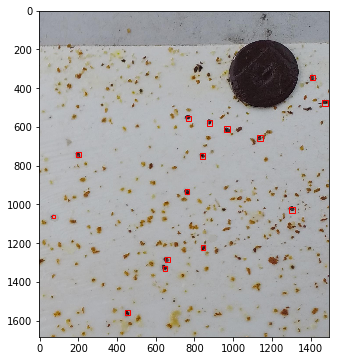

In [29]:
import random
temp=round(len(train_name)*random.random())
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(train_image[train_name[temp]])
plot_bbox(train_bbox[train_name[temp]],ax)

# Part 1: Finding varroas by segmentation

Another way of data loading for segmentation part.

In [1]:
import tarfile
import os
import numpy as np
import skimage
import scipy.ndimage as ndimage
from skimage import measure
import cv2 as cv
import scipy.stats 
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from scipy import ndimage, misc, signal
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.neighbors import KNeighborsClassifier
from tempfile import TemporaryFile

In [2]:
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'project-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [3]:
def r_files(filename):
    w = ET.parse(filename)
    files=[]
    for file in w.findall('object'):
        file_struct={}
        file_struct['name']=file.find('name').text
        b=file.find('bndbox')
        file_struct['bbox']=[int(float(b.find('xmin').text)), int(float(b.find('ymin').text)), 
                             int(float(b.find('xmax').text))-int(float(b.find('xmin').text)), 
                             int(float(b.find('ymax').text))-int(float(b.find('ymin').text))]
        files.append(file_struct)
    return files

In [4]:
os.listdir('../data/project-data/')
image_direc = '../data/project-data/'
image_d = dict()
true_d = dict()
image_class = ['train', 'validation', 'test']
for image in image_class:
    with open(f'{image_direc}/{image}.txt', 'r') as f:
        file_name = f.read().split('\n')
    image_d[image] = skimage.io.imread_collection([f'{image_direc}/images/{image}/{name}.jpg' for name in file_name])
    true_d[image] = [r_files(f'{image_direc}/annotations/{image}/{name}.xml') for name in file_name]

# 1.1 Segmenation with Thresholding

In [5]:
def img_equalization(img1):
    img=img1
    hist,bins = np.histogram(img.flatten(),256,[0,256])
    cdf= hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    img2 = cdf[img]
    return img2

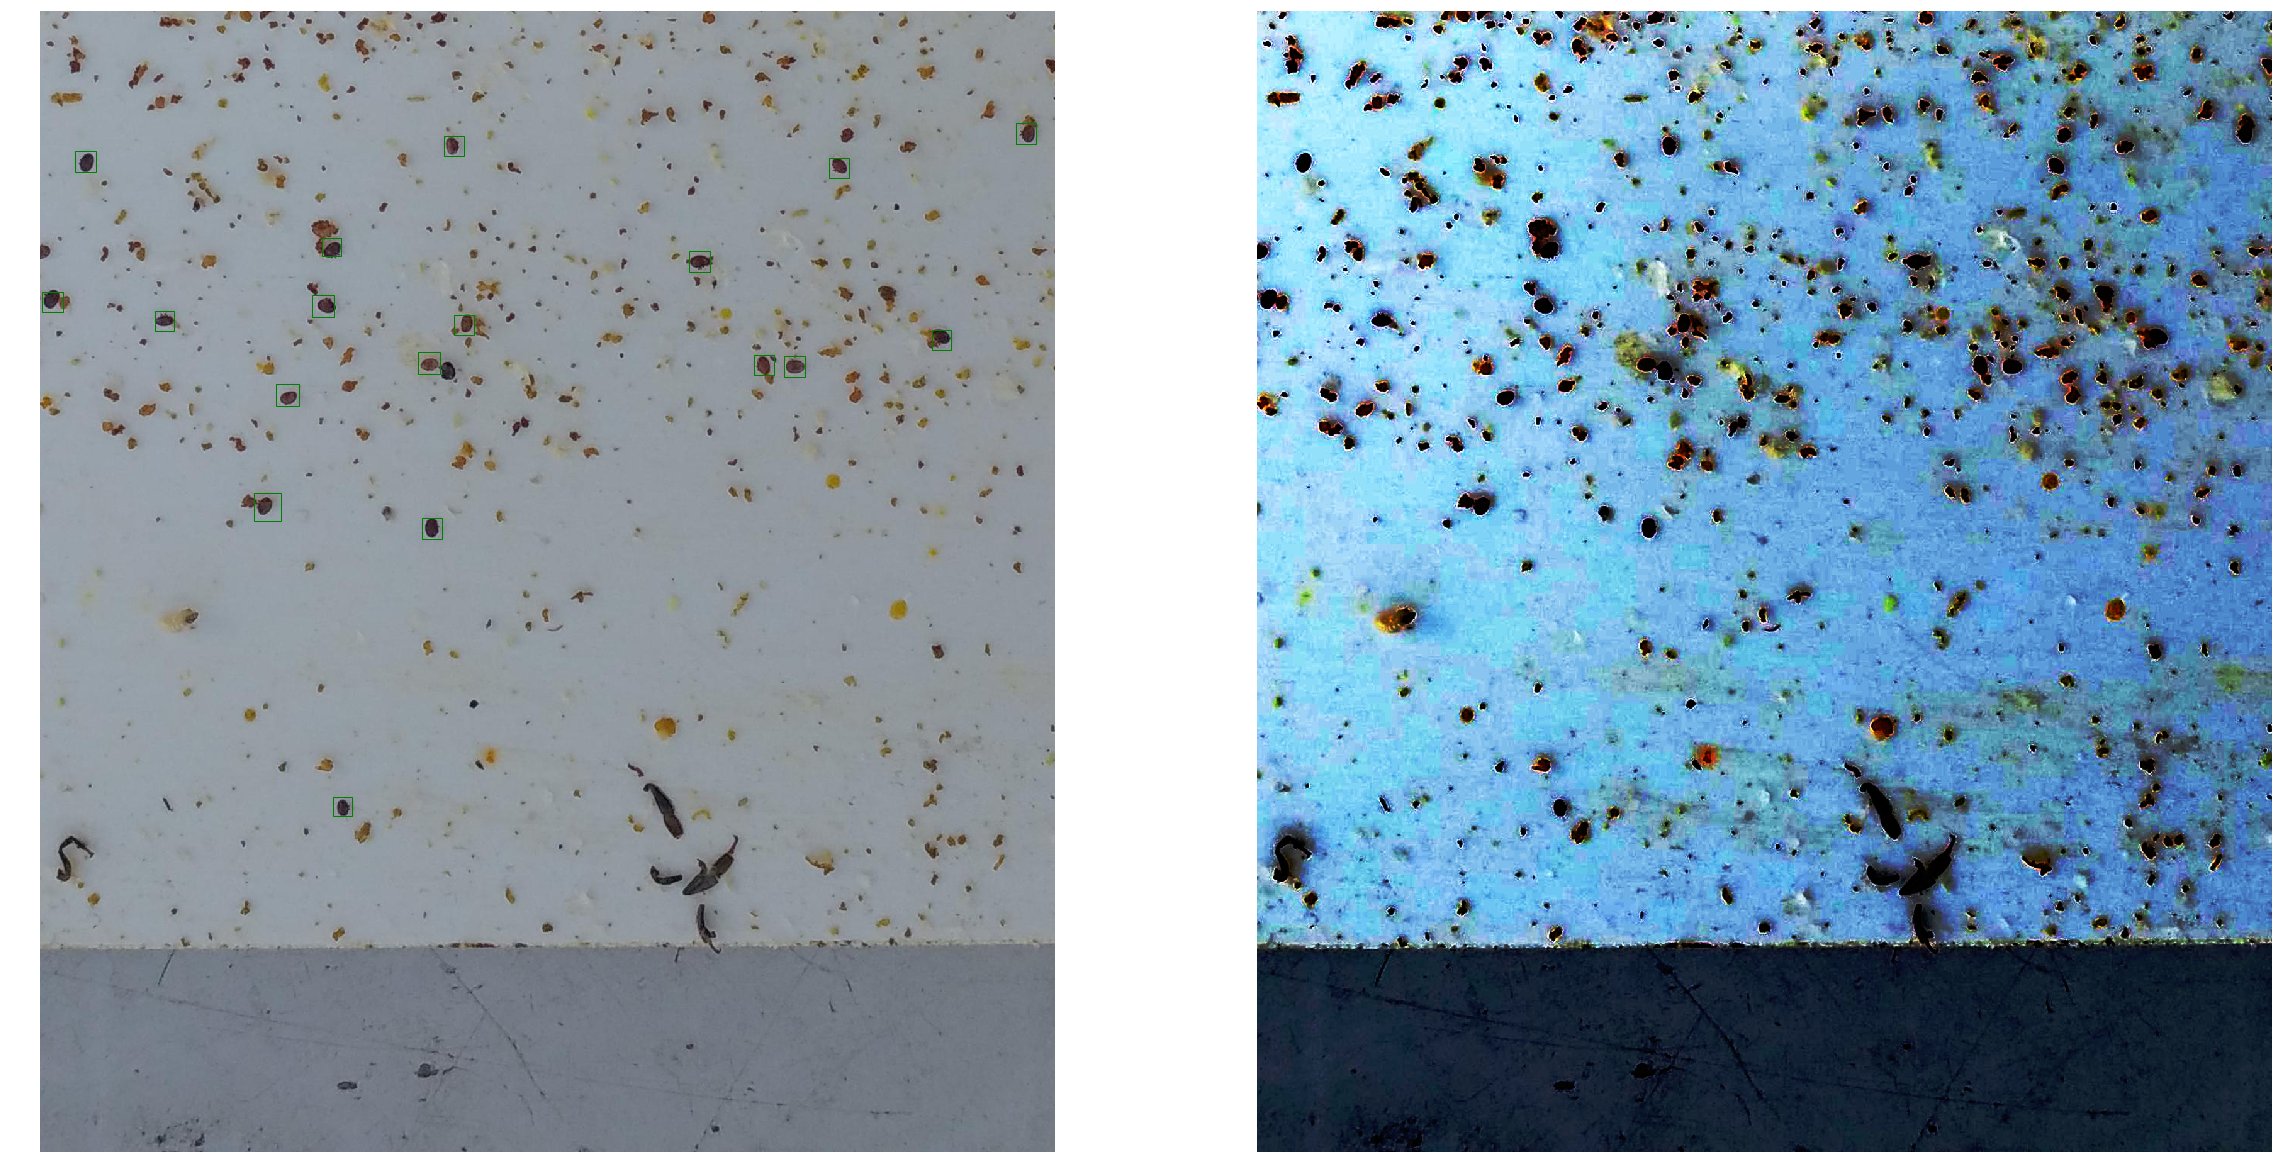

In [6]:
#ELEMENT NUMBER OF IMAGES IN FOLDER 'test'
k=2

img_0=image_d['test'][k]
img=img_equalization(img_0)

true_boxes = [item['bbox'] for item in true_d['test'][k]]

fig, ax = plt.subplots(1, 2, figsize=(40, 40))
ax[0].imshow(img_0, cmap='gray')
ax[0].axis('off')
for b in true_boxes:
    rect = patches.Rectangle((b[0], b[1]), b[2], b[3], linewidth=1,edgecolor='g',facecolor='none')
    # Add the patch to the Axes
    ax[0].add_patch(rect)  
ax[1].imshow(img, cmap='gray')
ax[1].axis('off')
plt.show()

In [7]:
def thresholding_segmentation(image):
    #image equalization
    img1=image
    img2=img_equalization(img1)
    
    gray_image=skimage.color.rgb2gray(img1)*255
    # automatically find the minimal threshold
    temp_threshold=skimage.filters.threshold_minimum(gray_image)
    # get the labels that's larger than the set threshold, and store in candidates
    varroa_labels = skimage.measure.label(gray_image>temp_threshold,background=True,connectivity=2)
    candidates=skimage.measure.regionprops(varroa_labels)
    
    bw=(gray_image>temp_threshold)*255
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    #ax.set_title('Binary image from thresholding segmentation')
    #ax.imshow(bw, cmap='gray')
    #ax.axis('off')
    #plt.show()
    
    box=[]
    # visualize bounding box of varroa_candidate along with original image
    for candidate in candidates:
        temp_bbox = [candidate['bbox'][1], candidate['bbox'][0], candidate['bbox'][3] - candidate['bbox'][1], 
                candidate['bbox'][2] - candidate['bbox'][0]]
        box.append(temp_bbox)
    return (np.asarray(box), candidates, bw)

In [8]:
def plot_img_boxed(img,true_box,box,title):
    img1=img
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_title(title)
    ax.imshow(img1, cmap='gray')
    # Create a Rectangle patch
    for b in box:
        rect = patches.Rectangle((b[0], b[1]), b[2], b[3], linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    for b in true_box:
        rect = patches.Rectangle((b[0], b[1]), b[2], b[3], linewidth=1,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)  
    ax.axis('off')
    plt.show()

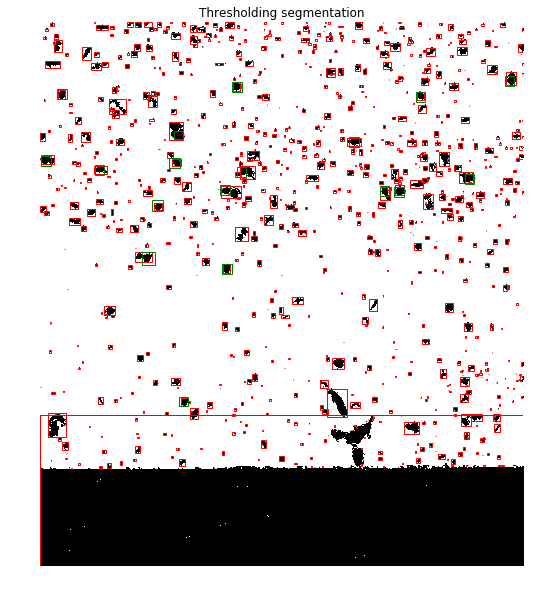

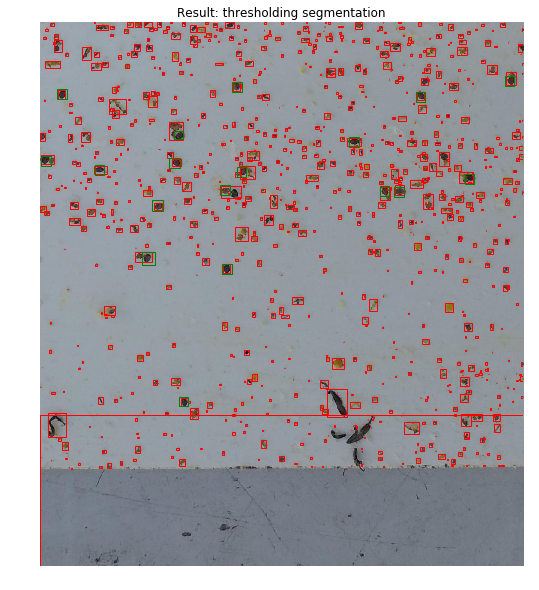

In [9]:
#Result from Thresholding
box_varroa_candidate, varroa_candidate, im_seg=thresholding_segmentation(img_0)
plot_img_boxed(im_seg,true_boxes,box_varroa_candidate,'Thresholding segmentation')
plot_img_boxed(img_0,true_boxes,box_varroa_candidate,'Result: thresholding segmentation')

# 1.2 Segmenation with Edge detection

In [10]:
def edge_segmentation(img):
    #image equalization
    img1=img
    gray_image=skimage.color.rgb2gray(img1)*255
    edge=skimage.filters.sobel(gray_image)
    edge_bw=np.invert((edge > 15)*255)
    
    # Copy the thresholded image.
    im_floodfill = edge_bw.copy()
    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = edge_bw.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv.floodFill(im_floodfill, mask, (0,0), 255);
    im_floodfill=(im_floodfill>10)*255

    # Invert floodfilled image
    im_floodfill_inv = cv.bitwise_not(im_floodfill)

    # Closing binary image
    kernel = np.ones((2,2), np.uint8) 
    im_out= closing(im_floodfill,square(3))
    
    #fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    #ax.set_title('Binary image from edge segmentation')
    #ax.imshow(im_out, cmap='gray')
    #ax.axis('off')
    #plt.show()

    # label image regions
    varroa_labels = skimage.measure.label(im_out>0,background=True,connectivity=2)
    candidates=skimage.measure.regionprops(varroa_labels)

    box=[]
    # visualize bounding box of varroa_candidate along with original image
    for candidate in candidates:
        temp_bbox = [candidate['bbox'][1], candidate['bbox'][0], candidate['bbox'][3] - candidate['bbox'][1], 
                     candidate['bbox'][2] - candidate['bbox'][0]]
        box.append(temp_bbox)
    return (np.asarray(box), candidates, im_out)

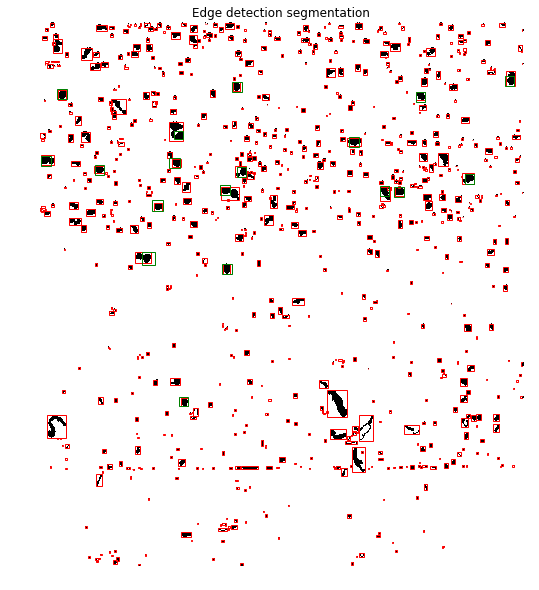

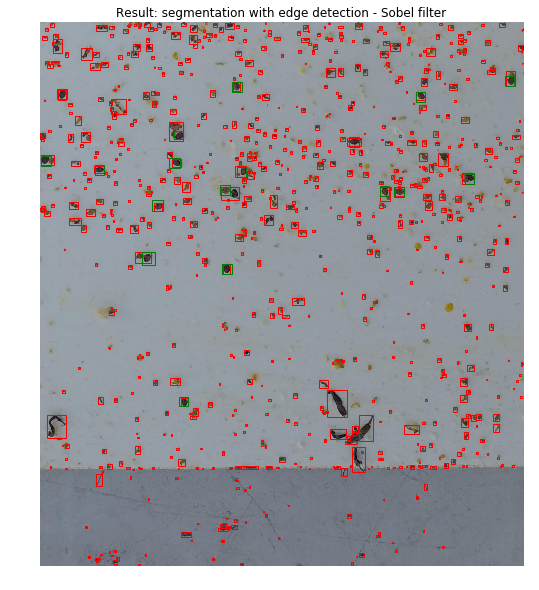

In [11]:
#Result from Edge detection
box_varroa_candidate_2, varroa_candidate_2, im_seg_2=edge_segmentation(img_0)
plot_img_boxed(im_seg_2, true_boxes, box_varroa_candidate_2,'Edge detection segmentation')
plot_img_boxed(img_0, true_boxes, box_varroa_candidate_2,'Result: segmentation with edge detection - Sobel filter')

# 1.3 Size and eccentricity thresholding

In [12]:
#function that consider label prop list
#and return the size list (p=1) or the eccentricity list (p=2)
def create_prop_list(liste,area_th):
    prop_list_area=[]
    prop_list_ecc=[]
    for item in liste:
        if item.area<area_th:
            prop_list_area.append(item.area)
            prop_list_ecc.append(item.eccentricity)
    return (prop_list_area, prop_list_ecc)
            

In [13]:
def size_eccentricity_filter(varroa_candidate,box_varroa_candidate,area_min,area_max,ecc_min,ecc_max):
    area_MAX=10000; #first thresholding for huge detected object
    size_list, ecc_list=create_prop_list(varroa_candidate,area_MAX)
    
    box_varroa_candidate_filtered=[]
    #get the final candidate(varroa_candidate) box that satisfied the area and eccentricity
    for candidate, box in zip(varroa_candidate, box_varroa_candidate):
        area=box[2]*box[3]
        if (area>area_min and area<area_max and candidate.eccentricity>ecc_min and candidate.eccentricity<ecc_max ):
            box_varroa_candidate_filtered.append(box)
    return box_varroa_candidate_filtered

Text(0.5, 1.0, 'Groundtruth vorroa size distribution')

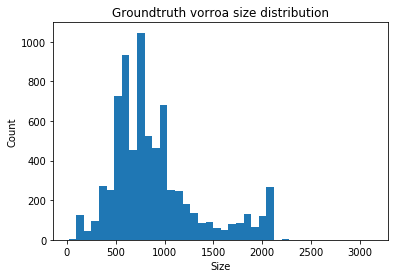

In [14]:
# Check avg vorroa size
size_list = []

for i in true_d['train']:
    for t in i:
        size_list.append(t["bbox"][2]*t["bbox"][2])
        

# Visualize the vorroa size distribution
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(size_list, bins = 40)
ax.set_xlabel('Size')
ax.set_ylabel('Count')
ax.set_title('Groundtruth vorroa size distribution')

# 1.4 Segmentation results and performance

In [15]:
def detect_by_segmentation(img,method,area_min,area_max,ecc_min,ecc_max):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    image=img;
    
    if method==1:
        varroa_box, varroa_candidate, im_seg_out = thresholding_segmentation(image)
    if method==2:
        varroa_box, varroa_candidate, im_seg_out = edge_segmentation(image)
        
    box_varroa_filtered=size_eccentricity_filter(varroa_candidate,varroa_box,area_min,area_max,ecc_min,ecc_max)
    return box_varroa_filtered

In [5]:
# calculate IOU of 2 bbox
def IoU(a, b):
    #intersection area
    dx = min(a[0] + a[2], b[0] + b[2]) - max(a[0], b[0])
    dy = min(a[1] + a[3], b[1] + b[3]) - max(a[1], b[1])
    if (dx <= 0 or dy <= 0):
        return 0
    # intersection area
    int_area = dx*dy
    # Calculate union length
    uni_area = a[2] * a[3] + b[2] * b[3] - int_area
    
    return int_area / uni_area

In [6]:
# calculate precision, recall and f1_score according to input thrshold
def cal_stats(values, thrs, gtl):

    # Get boolean judgment for values using thrs
    results = np.asarray(values) > thrs
    
    # Get prec
    prec = np.sum(results) / len(values)
    
    # Get rec
    rec = np.sum(results) / gtl
    
    # Get f1_score
    f1 = 2 * prec * rec / (prec + rec)
    
    return (prec, rec, f1)

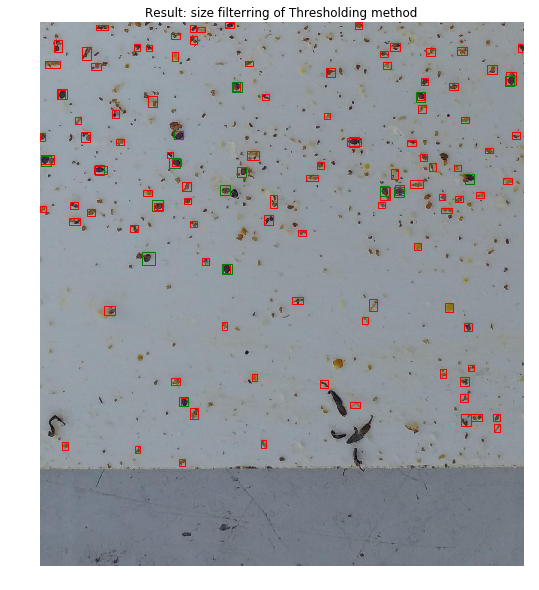

Precision: 0.125
Recall: 0.7222222222222222
F1: 0.21311475409836064


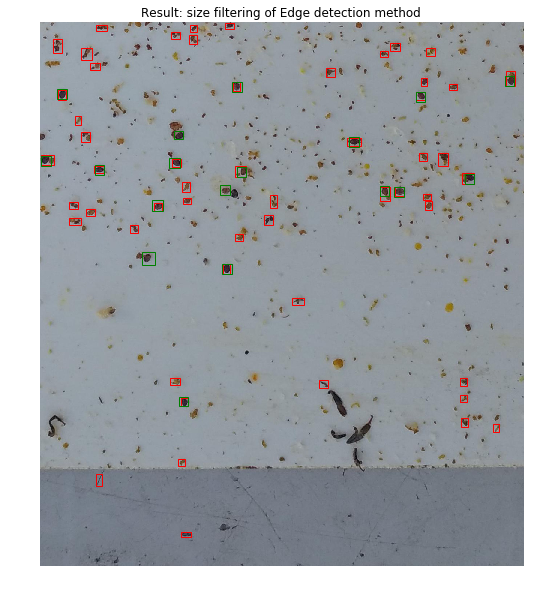

Precision: 0.2777777777777778
Recall: 0.8333333333333334
F1: 0.4166666666666667


In [18]:
test_1=detect_by_segmentation(img_0,1,400,1500,0,1) # input=(image,seg method,area_min,area_max,ecc_min,ecc_max)
test_2=detect_by_segmentation(img_0,2,550,1500,0,1) # seg method=(1=thresholding,2=edge detection)

if len(true_boxes)!=0:
    # Get the max IoU score for each filtered detected obj
    iou_scores = [np.max([IoU(detected, gt) for gt in true_boxes]) for detected in test_1]
    iou_scores_2 = [np.max([IoU(detected_2, gt_2) for gt_2 in true_boxes]) for detected_2 in test_2]
    # Get statistics for current img
    prec, rec, f1 = cal_stats(iou_scores, thrs = 0.3, gtl = len(true_boxes))
    prec_2, rec_2, f1_2 = cal_stats(iou_scores_2, thrs = 0.3, gtl = len(true_boxes))

    #Plotting results
    plot_img_boxed(img_0, true_boxes,test_1,'Result: size filterring of Thresholding method')
    print(f'Precision: {prec}\nRecall: {rec}\nF1: {f1}')

    plot_img_boxed(img_0, true_boxes,test_2,'Result: size filtering of Edge detection method')
    print(f'Precision: {prec_2}\nRecall: {rec_2}\nF1: {f1_2}')

In [19]:
# find average of prec, rec, f1
f1_list = []
f1_list_2 = []
prec_list = []
prec_list_2 = []
rec_list = []
rec_list_2 = []

for jj in range(50):
    image_test=image_d['test'][jj]
    gt_boxes = [item['bbox'] for item in true_d['test'][jj]]
    
    try:
        seg_1=detect_by_segmentation(image_test,1,400,1500,0,1) # input=(image,seg method,area_min,area_max,ecc_min,ecc_max)
        seg_2=detect_by_segmentation(image_test,2,550,1500,0,1)

        if len(gt_boxes)!=0:
            # Get the max IoU score for each filtered detected obj
            iou_scores = [np.max([IoU(detected, gt) for gt in gt_boxes]) for detected in seg_1]
            iou_scores_2 = [np.max([IoU(detected_2, gt_2) for gt_2 in gt_boxes]) for detected_2 in seg_2]
            # Get statistics for current img
            prec, rec, f1 = cal_stats(iou_scores, thrs = 0.3, gtl = len(gt_boxes))
            prec_2, rec_2, f1_2 = cal_stats(iou_scores_2, thrs = 0.3, gtl = len(gt_boxes))

        f1_list.append(f1)
        f1_list_2.append(f1_2)
        rec_list.append(rec)
        rec_list_2.append(rec_2)
        prec_list.append(prec)
        prec_list_2.append(prec_2)
    except:
        pass

f1_list=np.asarray(f1_list)
f1_list_2=np.asarray(f1_list_2)
prec_list=np.asarray(prec_list)
prec_list_2=np.asarray(prec_list_2)
rec_list=np.asarray(rec_list)
rec_list_2=np.asarray(rec_list_2)

print('Average Results from thresholding')
print(f'Precision: {prec_list[~np.isnan(prec_list)].mean()}\nRecall: {rec_list[~np.isnan(rec_list)].mean()}\nF1: {f1_list[~np.isnan(f1_list)].mean()}')
print('Average Results from edge detection')
print(f'Precision: {prec_list_2[~np.isnan(prec_list_2)].mean()}\nRecall: {rec_list_2[~np.isnan(rec_list_2)].mean()}\nF1: {f1_list_2[~np.isnan(f1_list_2)].mean()}')



Average Results from thresholding
Precision: 0.2409740104718229
Recall: 0.6185892446893075
F1: 0.3562600771147491
Average Results from edge detection
Precision: 0.15654902317075714
Recall: 0.6862353045950439
F1: 0.24559017694330584


# Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

### Detailed information of getting the 25*25*3 sliding windows is given in Part 3.1.1

It should be noted that in this part, we only use a small part of data (about 30,000 out of 300,000) to explore the performance of different descriptors. It is assumed that the score will improve if we increase the number of dataset. Since we put our emphasis on neural network, we will implement full 300,000 data in part 3.

# 2.1 Load true and false cropped varroa images and creation of descriptors

In [20]:
#Load descriptors true false
with open("true.txt", "rb") as fp:   # Unpickling
    true_varroa_prop = pickle.load(fp)
with open("true_2.txt", "rb") as fp:   # Unpickling
    true_varroa_prop_2 = pickle.load(fp)
with open("false.txt", "rb") as fp:   # Unpickling
    false_varroa_prop = pickle.load(fp)
with open("false_2.txt", "rb") as fp:   # Unpickling
    false_varroa_prop_2 = pickle.load(fp)

true_varroa_prop=true_varroa_prop[0:len(false_varroa_prop)]
true_varroa_prop_2=true_varroa_prop[0:len(false_varroa_prop_2)]

In [21]:
#Functions for descriptors from GroundTruth

def get_area(prop_list):
    prop_list_area=[]
    for item in prop_list:
        prop_list_area.append(item.area)
    return prop_list_area

def get_eccentricity(prop_list):
    prop_list_ecc=[]
    for item in prop_list:
        prop_list_ecc.append(item.eccentricity)
    return prop_list_ecc

def get_perimeter(prop_list):
    prop_list_perimeter=[]
    for item in prop_list:
        prop_list_perimeter.append(item.perimeter)
    return prop_list_perimeter

def get_convex_area(prop_list): #area of polygon around and outside the object
    prop_list_conv=[]
    for item in prop_list:
        prop_list_conv.append(item.convex_area)
    return prop_list_conv

def get_solidity(prop_list):
    prop_list_sol=[]
    for item in prop_list:
        prop_list_sol.append(item.solidity)
    return prop_list_sol

def get_moments(prop_list,i,j): #n=0,1,2,3
    prop_list_mom=[]
    for item in prop_list:
        prop_list_mom.append(item.moments[i][j])
    return prop_list_mom

def get_euler(prop_list):
    prop_list_euler=[]
    for item in prop_list:
        prop_list_euler.append(item.euler_number)
    return prop_list_euler

def get_major_axis(prop_list):
    prop_list_major=[]
    for item in prop_list:
        prop_list_major.append(item.major_axis_length)
    return prop_list_major

def data_x_y(x,y):
    data=[]
    for a,b in zip(x,y):
        data.append([a,b])
    return data

# calculate paramters of Gaussian
def get_coefficient(data):
    m=np.mean(data, axis=0)
    sig=np.cov(data.T)
    return (m, sig)

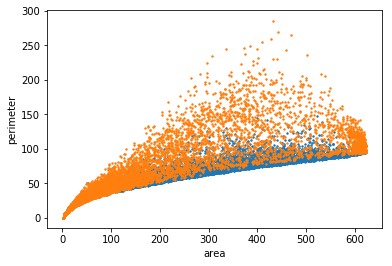

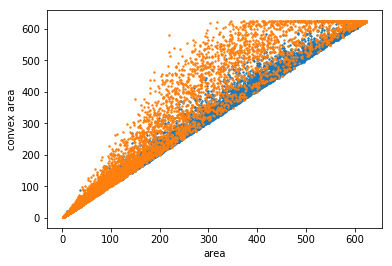

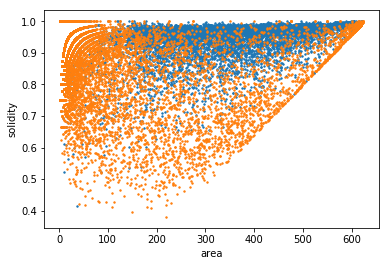

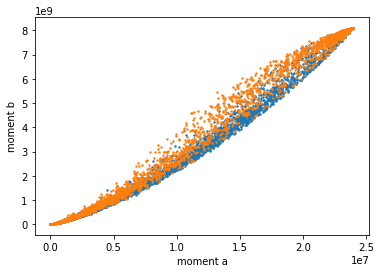

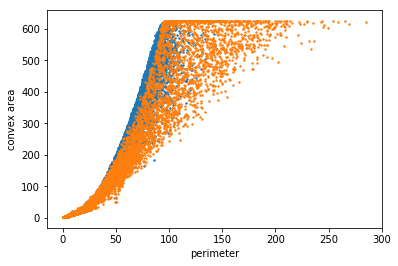

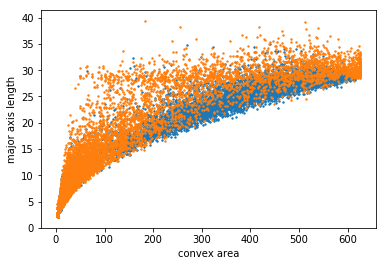

In [22]:
#get and save true,false descriptors for thresholding method

#true descriptors
area_gt=get_area(true_varroa_prop)
perimeter_gt=get_perimeter(true_varroa_prop)
eccentricity_gt=get_eccentricity(true_varroa_prop)
convex_area_gt=get_convex_area(true_varroa_prop)
solidity_gt=get_solidity(true_varroa_prop)
moment_a_gt=get_moments(true_varroa_prop,2,2)
moment_b_gt=get_moments(true_varroa_prop,3,3)
euler_gt=get_euler(true_varroa_prop)
major_ax_gt=get_major_axis(true_varroa_prop)

#false descriptors
area_f=get_area(false_varroa_prop)
perimeter_f=get_perimeter(false_varroa_prop)
eccentricity_f=get_eccentricity(false_varroa_prop)
convex_area_f=get_convex_area(false_varroa_prop)
solidity_f=get_solidity(false_varroa_prop)
moment_a_f=get_moments(false_varroa_prop,2,2)
moment_b_f=get_moments(false_varroa_prop,3,3)
euler_f=get_euler(false_varroa_prop)
major_ax_f=get_major_axis(false_varroa_prop)

plt.scatter(area_gt, perimeter_gt,2)
plt.scatter(area_f, perimeter_f,2)
plt.xlabel('area')
plt.ylabel('perimeter')
plt.show()

plt.scatter(area_gt, convex_area_gt,2)
plt.scatter(area_f, convex_area_f,2)
plt.xlabel('area')
plt.ylabel('convex area')
plt.show()

plt.scatter(area_gt, solidity_gt,2)
plt.scatter(area_f, solidity_f,2)
plt.xlabel('area')
plt.ylabel('solidity')
plt.show()

plt.scatter(moment_a_gt, moment_b_gt ,2)
plt.scatter(moment_a_f, moment_b_f ,2)
plt.xlabel('moment a')
plt.ylabel('moment b')
plt.show()

plt.scatter(perimeter_gt, convex_area_gt,2)
plt.scatter(perimeter_f, convex_area_f,2)
plt.xlabel('perimeter')
plt.ylabel('convex area')
plt.show()

plt.scatter(convex_area_gt, major_ax_gt,2)
plt.scatter(convex_area_f, major_ax_f,2)
plt.xlabel('convex area')
plt.ylabel('major axis length')
plt.show()

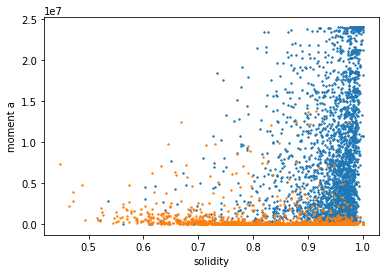

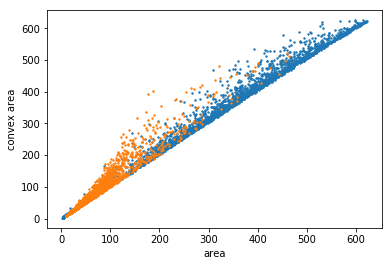

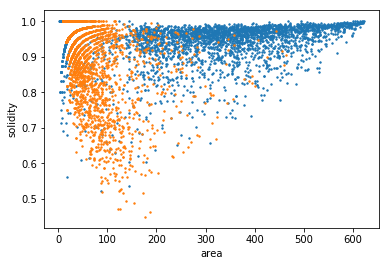

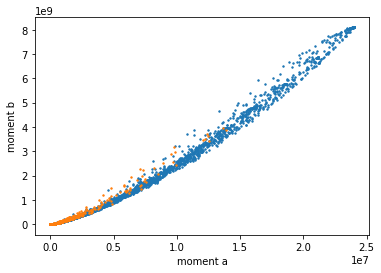

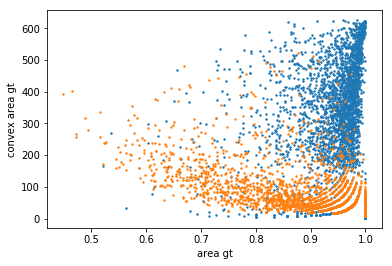

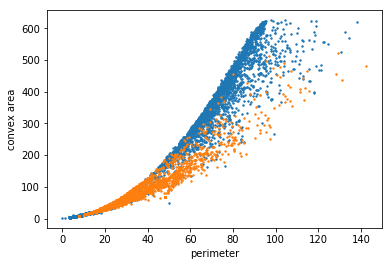

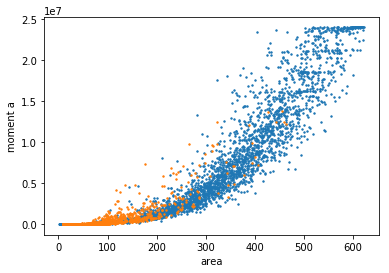

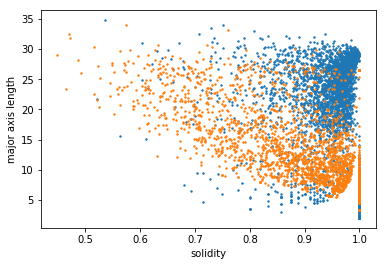

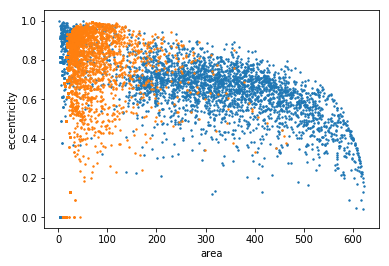

In [23]:
#get descriptors GT for edge detection method

#true varroa descriptors
area_gt_2=get_area(true_varroa_prop_2)
perimeter_gt_2=get_perimeter(true_varroa_prop_2)
eccentricity_gt_2=get_eccentricity(true_varroa_prop_2)
convex_area_gt_2=get_convex_area(true_varroa_prop_2)
solidity_gt_2=get_solidity(true_varroa_prop_2)
moment_a_gt_2=get_moments(true_varroa_prop_2,2,2)
moment_b_gt_2=get_moments(true_varroa_prop_2,3,3)
major_ax_gt_2=get_major_axis(true_varroa_prop_2)

#false varroa descriptors
area_f_2=get_area(false_varroa_prop_2)
perimeter_f_2=get_perimeter(false_varroa_prop_2)
eccentricity_f_2=get_eccentricity(false_varroa_prop_2)
convex_area_f_2=get_convex_area(false_varroa_prop_2)
solidity_f_2=get_solidity(false_varroa_prop_2)
moment_a_f_2=get_moments(false_varroa_prop_2,2,2)
moment_b_f_2=get_moments(false_varroa_prop_2,3,3)
major_ax_f_2=get_major_axis(false_varroa_prop_2)

plt.scatter(solidity_gt_2, moment_a_gt_2,2)
plt.scatter(solidity_f_2, moment_a_f_2, 2)
plt.xlabel('solidity')
plt.ylabel('moment a')
plt.show()

plt.scatter(area_gt_2, convex_area_gt_2,2)
plt.scatter(area_f_2, convex_area_f_2,2)
plt.xlabel('area')
plt.ylabel('convex area')
plt.show()

plt.scatter(area_gt_2, solidity_gt_2,2)
plt.scatter(area_f_2, solidity_f_2,2)
plt.xlabel('area')
plt.ylabel('solidity')
plt.show()

plt.scatter(moment_a_gt_2, moment_b_gt_2, 2)
plt.scatter(moment_a_f_2, moment_b_f_2, 2)
plt.xlabel('moment a')
plt.ylabel('moment b')
plt.show()

plt.scatter(solidity_gt_2, convex_area_gt_2,2)
plt.scatter(solidity_f_2, convex_area_f_2,2)
plt.xlabel('area gt')
plt.ylabel('convex area gt')
plt.show()

plt.scatter(perimeter_gt_2, convex_area_gt_2,2)
plt.scatter(perimeter_f_2, convex_area_f_2,2)
plt.xlabel('perimeter')
plt.ylabel('convex area')
plt.show()

plt.scatter(area_gt_2, moment_a_gt_2, 2)
plt.scatter(area_f_2, moment_a_f_2, 2)
plt.xlabel('area')
plt.ylabel('moment a')
plt.show()

plt.scatter(solidity_gt_2, major_ax_gt_2, 2)
plt.scatter(solidity_f_2, major_ax_f_2, 2)
plt.xlabel('solidity')
plt.ylabel('major axis length')
plt.show()

plt.scatter(area_gt_2, eccentricity_gt_2, 2)
plt.scatter(area_f_2, eccentricity_f_2, 2)
plt.xlabel('area')
plt.ylabel('eccentricity')
plt.show()

# 2.2 Bayes classifiers

In [24]:
# calculate the coefficient of quadratic term, primary term and constant term 
# of x and y according to the equation above
# in the end we round the coefficient to the closest integer
def get_discriminant_curve_coefficient(data_1,data_2):
    mean_1,sig_1=get_coefficient(data_1)
    mean_2,sig_2=get_coefficient(data_2)
    mean_11,mean_12=mean_1[0],mean_1[1]
    mean_21,mean_22=mean_2[0],mean_2[1]
    sig_11,sig_12=sig_1[0][0],sig_1[1][1]
    sig_21,sig_22=sig_2[0][0],sig_2[1][1]
    coef_x_2=(sig_21-sig_11)*sig_12*sig_22
    coef_x_1=(-2*mean_11*sig_21+2*mean_21*sig_11)*sig_12*sig_22
    coef_y_2=(sig_22-sig_12)*sig_11*sig_21
    coef_y_1=(-2*mean_12*sig_22+2*mean_22*sig_12)*sig_11*sig_21
    coef_constant_1=mean_11*mean_11*sig_12*sig_21*sig_22+mean_12*mean_12*sig_11*sig_21*sig_22
    coef_constant_2=-mean_21*mean_21*sig_11*sig_12*sig_22-mean_22*mean_22*sig_11*sig_12*sig_21
    coef_constant=coef_constant_1+coef_constant_2
    temp_array=np.array([coef_x_2,coef_x_1,coef_y_2,coef_y_1,coef_constant])
    temp_array=temp_array[np.flatnonzero(temp_array)]
    temp_min=min(abs(temp_array))
    #coef_x_2=coef_x_2/temp_min
    #coef_x_1=coef_x_1/temp_min
    #coef_y_2=coef_y_2/temp_min
    #coef_y_1=coef_y_1/temp_min
    #coef_constant=coef_constant/temp_min
    return coef_x_2, coef_x_1, coef_y_2, coef_y_1, coef_constant

In [25]:
def plot_Bayes_curve(data_gt, data_f, curve_coeff):
    x_min=min([np.amin(data_gt[:,0]),np.amin(data_f[:,0])])
    x_max=max([np.amax(data_gt[:,0]),np.amax(data_f[:,0])])
    y_min=min([np.amin(data_gt[:,1]),np.amin(data_f[:,1])])
    y_max=max([np.amax(data_gt[:,1]),np.amax(data_f[:,1])])

    x_range = np.arange(x_min, x_max, (x_max-x_min)/100)
    y_range = np.arange(y_min, y_max, (y_max-y_min)/100)
    x_range, y_range = np.meshgrid(x_range, y_range)
    curve = curve_coeff[0]*x_range*x_range + curve_coeff[1]*x_range + curve_coeff[2]*y_range*y_range + curve_coeff[3]*y_range + curve_coeff[4] 

    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111)
    ax.scatter(data_gt[:, 0], data_gt[:, 1], 2, label = 'True Varroa')
    ax.scatter(data_f[:, 0], data_f[:, 1], 2, label = 'False Varroa')
    ax.contour(x_range, y_range, curve, 0,linestyles='solid',colors='k',label='Curve')
    ax.legend()
    plt.show()

In [26]:
def point_class(curve_coeff, x, y): #(x,y)=point to classify
    t=curve_coeff[0]*x*x + curve_coeff[1]*x + curve_coeff[2]*y*y + curve_coeff[3]*y + curve_coeff[4]
    if (t>=0):
        return 1
    if (t<0):
        return 0

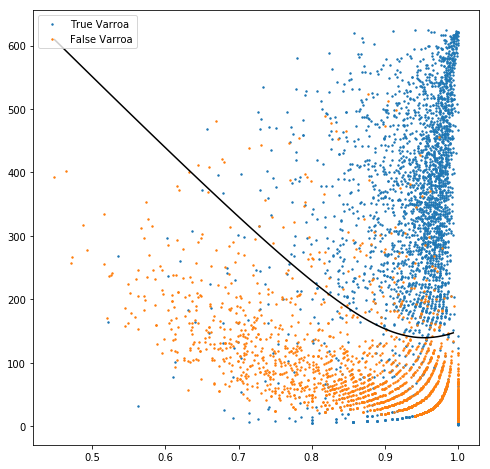

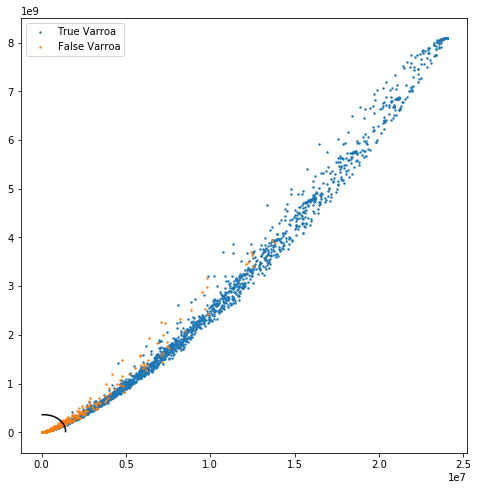

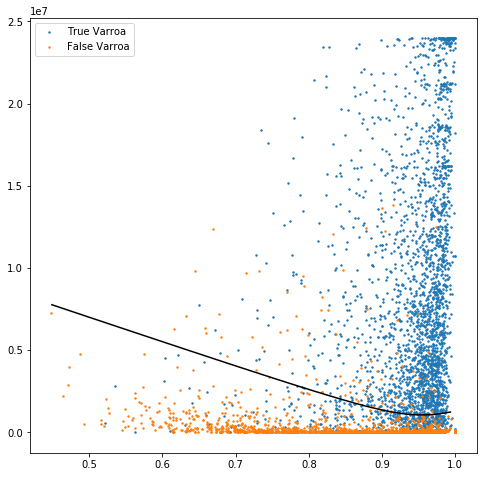

In [28]:
#1st classifier: Solidity vs Convex Area
data_gt_a=np.asarray(data_x_y(solidity_gt_2, convex_area_gt_2))
data_f_a=np.asarray(data_x_y(solidity_f_2,convex_area_f_2))
curve_coeff_a=get_discriminant_curve_coefficient(data_gt_a,data_f_a)
#Return coeff for (x^2,x,y^2,y,cst)

#2nd classifier: Moment_22 vs Moment_33
data_gt_b=np.asarray(data_x_y(moment_a_gt_2, moment_b_gt_2))
data_f_b=np.asarray(data_x_y(moment_a_f_2, moment_b_f_2))
curve_coeff_b=get_discriminant_curve_coefficient(data_gt_b,data_f_b)

#3th classifier: Solidity vs Moment_22
data_gt_c=np.asarray(data_x_y(solidity_gt_2, moment_a_gt_2))
data_f_c=np.asarray(data_x_y(solidity_f_2, moment_a_f_2))
curve_coeff_c=get_discriminant_curve_coefficient(data_gt_c,data_f_c)

plot_Bayes_curve(data_gt_a, data_f_a, curve_coeff_a)
plot_Bayes_curve(data_gt_b, data_f_b, curve_coeff_b)
plot_Bayes_curve(data_gt_c, data_f_c, curve_coeff_c)
                  

# 2.3 Sliding Window detector

A square window with dimension 25 pass through the image selected, for each step the image is cropped, segmented and 
there is classification.

The method for segmentation is edge detection (the method that gives best descriptors) instead of thresholding. The choice of classification is done depending on 3 Bayes classifiers: Solidity vs Convex Area, Moment_22 vs Moment_33 and
Solidity vs Moment_22.

Each Bayes classifiers gives as result 0 for a true varroa or 1 for a false varroa.


### Detailed information of getting the 25*25*3 sliding windows is given in Part 3.1.1

In [30]:
def detect_by_method_1(img,n_class): #n_class= number of classifier 0 = Solidity vs Convex Area
                                    #                              1 = Moment_22 vs Moment_33 
                                    #                              2 = Solidity vs Moment_22
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''
    d_window=25
    window=[0,0,d_window,d_window] #line,col,width,heigth
    d_img = img.shape

    box_detected_varroa=[]

    for ii in range(round(d_img[0]/d_window)):
        #print(ii)
        for jj in range(round(d_img[1]/d_window)):
            img_crop=img[window[0]:window[0]+window[2],window[1]:window[1]+window[3]] #[line1:line2,col1:col2]

            try:

                box_varroa_candidate, varroa_candidate, im_out = edge_segmentation(img_crop)
                
                ww=0   
                for candidate in varroa_candidate:   
                    #Solidity vs Convex Area
                    x_a = candidate.solidity
                    y_a = candidate.convex_area
                    #Moment_22 vs Moment_33 
                    x_b = candidate.moments[2][2]
                    y_b = candidate.moments[3][3]
                    #Solidity vs Moment_22
                    x_c = candidate.solidity
                    y_c = candidate.moments[2][2]

                    classification = [point_class(curve_coeff_a,x_a,y_a), point_class(curve_coeff_b,x_b,y_b), 
                                      point_class(curve_coeff_c,x_c,y_c)]

                    if classification[n_class] == 0:
                        box_varroa_candidate[ww][0]=box_varroa_candidate[ww][0]+jj*d_window
                        box_varroa_candidate[ww][1]=box_varroa_candidate[ww][1]+ii*d_window

                        box_detected_varroa.append(box_varroa_candidate[ww])
                    ww=ww+1
            except:
                pass
            window[1]=window[1]+d_window

        window[1]=0
        window[0]=window[0]+d_window

    return np.asarray(box_detected_varroa)

In [31]:
def area_filter(box,area_min,area_max):
    box_filtered=[]
    
    for b in box:
        if b[2]*b[3] > area_min and b[2]*b[3] < area_max:
            box_filtered.append(b)
    return box_filtered

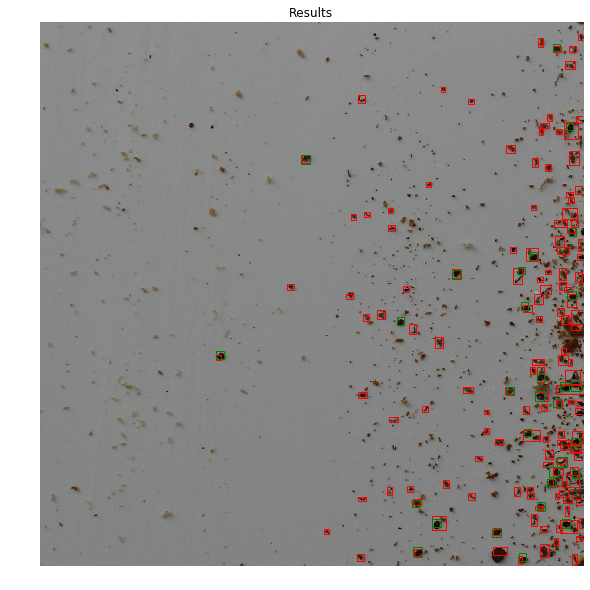

Precision: 0.13533834586466165
Recall: 0.6
F1: 0.22085889570552147


In [61]:
k=11

img_0=image_d['test'][k]
true_boxes = [item['bbox'] for item in true_d['test'][k]]


boxes=detect_by_method_1(img_0,1)
#boxes=area_filter(boxes,300,1500)
plot_img_boxed(img_0,true_boxes,boxes,'Results')

if len(true_boxes)!=0:
    # Get the max IoU score for each filtered detected obj
    iou_scores = [np.max([IoU(detected, gt) for gt in true_boxes]) for detected in boxes]
    # Get statistics for current img
    prec, rec, f1 = cal_stats(iou_scores, thrs = 0.3, gtl = len(true_boxes))
    print(f'Precision: {prec}\nRecall: {rec}\nF1: {f1}')

In [67]:
#Computation of f1 average on the set of "test"
f1_list=[]
prec_list=[]
rec_list=[]

for ii in range(49):
    img_0=image_d['test'][ii]
    true_boxes = [item['bbox'] for item in true_d['test'][ii]]


    boxes=detect_by_method_1(img_0,0)
    boxes=area_filter(boxes,100,1500)

    if len(true_boxes)!=0:
        # Get the max IoU score for each filtered detected obj
        iou_scores = [np.max([IoU(detected, gt) for gt in true_boxes]) for detected in boxes]
        # Get statistics for current img
        prec, rec, f1 = cal_stats(iou_scores, thrs = 0.3, gtl = len(true_boxes))
        if prec>=0 and prec<=1:
            prec_list.append(prec)
        if rec>=0 and rec<=1:
            rec_list.append(rec)
        if f1>=0 and f1<=1:
            f1_list.append(f1)
    
avg_prec=np.mean(np.array(prec_list))
avg_rec=np.mean(np.array(rec_list))
avg_f1=np.mean(np.array(f1_list))
print('Average precision is '+str(avg_prec))
print('Average recall is '+str(avg_rec))
print('Average f1 score is '+str(avg_f1))

Average precision is 0.09660784532969262
Average recall is 0.26463083141264154
Average f1 score is 0.15949787820658087


It should be noted that in this part, we only use a small part of data (about 30,000 out of 300,000) to explore the performance of different descriptors. It is assumed that the score will improve if we increase the number of dataset. Since we put our emphasis on neural network, we will implement full 300,000 data in part 3.

# Part 3: Using MLP and CNNs



## 3.1 Sliding Window Classification

### 3.1.1 Getting dataset for training neural networks

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation, Reshape
from keras.optimizers import SGD, Adam
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

Using TensorFlow backend.


In [5]:
train_name,train_image,train_bbox=get_dataset(800,data_type='train')
val_name,val_image,val_bbox=get_dataset(150,data_type='validation')
#test_name,test_image,test_bbox=get_dataset(50,data_type='test')

In [8]:
bbox_length = [temp_bbox['bbox'][2] for (temp_name, temp_bboxes) in train_bbox.items() for temp_bbox in temp_bboxes]
bbox_width = [temp_bbox['bbox'][3] for (temp_name, temp_bboxes) in train_bbox.items() for temp_bbox in temp_bboxes]

Text(0.5,1,'Widths of Bounding Box')

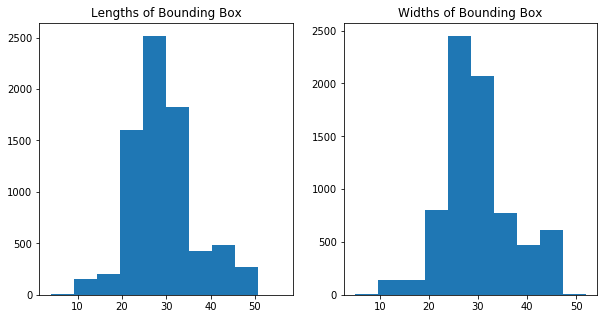

In [14]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.hist(bbox_length)
ax1.set_title('Lengths of Bounding Box')
ax2.hist(bbox_width)
ax2.set_title('Widths of Bounding Box')

### according to the hisogram, we choose the size of sliding window to (25,25)

In [112]:
# get 25*25*3 sliding window that contains major information of a ground truth bounding box
# do some small random transition to work as data augumentation
# label each generated window as 1, meaning windows that contain varroa
import random

def get_gt_sw_dataset(name,image,bbox,size=25):
    new_image=[]
    new_label=[]
    for temp_name in name:
        for temp_bbox in bbox[temp_name]:
            temp_image=image[temp_name]
            for i in range(3):
                try:
                    xmin=temp_bbox['bbox'][0]
                    ymin=temp_bbox['bbox'][1]
                    width=temp_bbox['bbox'][2]
                    height=temp_bbox['bbox'][3]
                    # definition of transition
                    # make sure the box after transition still contains most information of single varroa
                    if size>=width:
                        temp_width_transition=int(0.3*(width-size)*random.random())
                    else:
                        temp_width_transition=int(0.3*(width/2-size*random.random()))
                    if size>=height:
                        temp_height_transition=int(0.3*(height-size)*random.random())
                    else:
                        temp_height_transition=int(0.3*(height/2-size*random.random()))
                    temp_new_image=temp_image[ ymin+temp_height_transition:ymin+temp_height_transition+size,
                                              xmin+temp_width_transition:xmin+temp_width_transition+size,:]
                    temp_new_image=cv2.resize(temp_new_image,(size,size)) 
                    new_image=new_image+[temp_new_image]
                except:
                    continue
    new_label=[1]*len(new_image)
    return np.array(new_image),np.array(new_label)

Size of Ground Truth Images is (14947, 25, 25, 3)


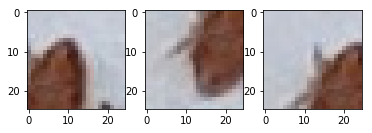

In [114]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
for i in [ax1,ax2,ax3]:
    train_gt_image,train_gt_label=get_gt_sw_dataset(train_name,train_image,train_bbox)
    i.imshow(train_gt_image[56])
print('Size of Ground Truth Images is ' +str(train_gt_image.shape))


We can see that there is different reasonable transition for each ground truth bounding box, and it can work as data augumentation.

In [115]:
# define whether window and ground truth bbox overlaps according to input threshold
def whether_overlap(sw, gt_bbox, threshold=100):
    # sw:xmin,ymin,xmax,ymax
    #bbox:xmin,ymin,width,height
    overlap_area=max(0, min(sw[2], (gt_bbox[2]+gt_bbox[0])) - max(sw[0], gt_bbox[0])) *\
                      max(0, min(sw[3], (gt_bbox[3]+gt_bbox[1])) - max(sw[1], gt_bbox[1]))
    return overlap_area > threshold

In [116]:
# get slding windows that do not have information of ground truth varroa
# randomly crop 250 25*25*3 windows among each image and make sure they don't overlap with ground truth bbox
# label each generated window as 0, meaning windows without varroa
import random
def get_random_sliding_window_dataset(name,image,bbox,size=25,sw_per_image=250):
    new_image=[]
    new_label=[]
    for temp_name in name:
        temp_image=image[temp_name]
        temp_width=temp_image.shape[0]
        temp_height=temp_image.shape[1]
        i=0
        while i<sw_per_image:

            xmin = random.randint(0,temp_height)
            ymin = random.randint(0,temp_width)
            temp_sw=[xmin,ymin,xmin+size,ymin+size]
            if_overlap=0
            # make sure do not overlap with any ground truth bbox
            for temp_bbox in bbox[temp_name]:
                temp_gt_bbox=temp_bbox['bbox']
                if whether_overlap(temp_sw,temp_gt_bbox):
                    if_overlap=1
                    break
           
            if if_overlap==0:
                try:
                    temp_new_image=temp_image[ ymin:ymin+size,xmin:xmin+size,:]

                    if temp_new_image.shape[0]==size and temp_new_image.shape[1]==size:
                        new_image=new_image+[temp_new_image]

                except:
                    continue

    new_label=[0]*len(new_image)
    return np.array(new_image),np.array(new_label)
                    
            

Size of False Images is (200000, 25, 25, 3)


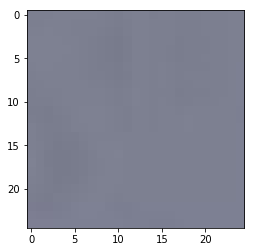

In [131]:
train_false_image,train_false_label=get_random_sliding_window_dataset(train_name,train_image,train_bbox)
print('Size of False Images is ' +str(train_false_image.shape))
plt.imshow(train_false_image[12])

In [132]:
# merge images and labels generated above ,with and without varroa
temp_train_images=np.concatenate((train_false_image,train_gt_image),axis=0)
temp_train_label=np.concatenate((train_false_label,train_gt_label),axis=0)

In [133]:
# give the whole images and corresponding labels with random order
# to avoid very bisaed data in each batch size
from random import shuffle
temp_index=[i for i in range(len(temp_train_images))]
shuffle(temp_index)
x_train=temp_train_images[temp_index]
y_train=temp_train_label[temp_index]

So far, we generate image and labels for training.

In [134]:
# use the same method to create validation data
val_gt_image,val_gt_label=get_gt_sw_dataset(val_name,val_image,val_bbox)
val_false_image,val_false_label=get_random_sliding_window_dataset(val_name,val_image,val_bbox)
x_val=np.concatenate((val_gt_image,val_false_image),axis=0)
y_val=np.concatenate((val_gt_label,val_false_label),axis=0)

In [145]:
# save training data and validation data
np.save('x_train.npy',x_train)
np.save('y_train.npy',y_train)
np.save('x_val.npy',x_val)
np.save('y_val.npy',y_val)

In [138]:
# load training data and validation data for keras
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')
y_train = keras.utils.to_categorical(y_train)
y_val = keras.utils.to_categorical(y_val)

## 3.1.2 Choosing best neural network

It should be noted that the x_train, y_train, x_val, y_val used in 3.1.2 is not data used for final training. They're only a small part of final training data, which contain about 30,000 out of 300,000 images and labels. This part is to choose the best model based on small part of data.

### Try MLP first

In [142]:
from keras import regularizers
# build MLP models with desired hyperparameters and layers
def create_mlp(optimizer, lr=0.01,
                      input_dim=1875, hidden_dim=64, output_dim=2,
                      hidden_activation='relu',
                      output_activation='softmax',
                      loss_fn='categorical_crossentropy',metrics=['accuracy'],
                      kernel_reg = regularizers.l1(0.001),
                      bias_reg = regularizers.l1(0.001),
                      batchNormalization = True,
                      drop_prob = 0):
    
    model = Sequential()
    model.add(Reshape((1875,), input_shape=(25,25,3)))
    model.add(Dense(hidden_dim, 
                    input_dim=input_dim, 
                    use_bias=True, 
                    kernel_regularizer=kernel_reg, 
                    bias_regularizer = bias_reg)) #activity_regularizer=regularizers.l2(0.001)
    if(batchNormalization):
        model.add(BatchNormalization())
    model.add(Activation(hidden_activation))
    # here we did not need dropout from the input layer which will reduce information
        
    for i in range(1):
        model.add(Dense(hidden_dim, input_dim=hidden_dim))
        if(batchNormalization):
            model.add(BatchNormalization())
        model.add(Activation(hidden_activation))
        if(drop_prob != 0):
            model.add(Dropout(drop_prob))
    model.add(Dense(output_dim, input_dim=hidden_dim, activation = output_activation))
    model.compile(loss = loss_fn, optimizer = optimizer, metrics = metrics)
    model.optimizer.lr=lr
    return model



In [145]:
# create naive MLP
model_naive_mlp  = create_mlp( 'Adam',hidden_dim=64,
                                      batchNormalization = False,
                                      drop_prob = 0)

model_naive_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1875)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                120064    
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 130       
Total params: 124,354
Trainable params: 124,354
Non-trainable params: 0
_________________________________________________________________


In [154]:
model_naive_mlp_history = model_naive_mlp.fit(x_train, y_train,
                                            batch_size=128,
                                            epochs=50,
                                            validation_data = (x_val, y_val),
                                            
                                            )

Train on 30947 samples, validate on 6073 samples
Epoch 1/50
30947/30947 [==============================] - 1s 30us/step - loss: 7.9276 - acc: 0.5170 - val_loss: 8.2952 - val_acc: 0.4940
Epoch 2/50
30947/30947 [==============================] - 1s 27us/step - loss: 7.9276 - acc: 0.5170 - val_loss: 8.2985 - val_acc: 0.4940
Epoch 3/50
30947/30947 [==============================] - 1s 28us/step - loss: 7.9276 - acc: 0.5170 - val_loss: 8.2989 - val_acc: 0.4940
Epoch 4/50
30947/30947 [==============================] - 1s 32us/step - loss: 7.9276 - acc: 0.5170 - val_loss: 8.2992 - val_acc: 0.4940
Epoch 5/50
30947/30947 [==============================] - 1s 31us/step - loss: 7.9276 - acc: 0.5170 - val_loss: 8.2991 - val_acc: 0.4940
Epoch 6/50
30947/30947 [==============================] - 1s 31us/step - loss: 7.9276 - acc: 0.5170 - val_loss: 8.2980 - val_acc: 0.4940
Epoch 7/50
30947/30947 [==============================] - 1s 32us/step - loss: 7.9276 - acc: 0.5170 - val_loss: 8.2988 - val_acc:

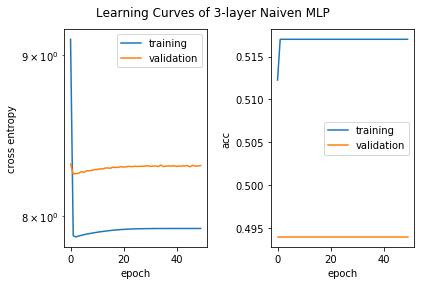

In [153]:
plot_history(model_naive_mlp_history,'cross entropy','acc','Learning Curves of 3-layer Naiven MLP')

In [148]:
# create tuned MLP by adding tricks like batch normalization and dropout
model_tuned_mlp  = create_mlp( 'Adam',hidden_dim=64,
                                      batchNormalization = True,
                                      drop_prob = 0.15)

model_tuned_mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1875)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                120064    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
activation_6 (Activation)    (None, 64)                0         
__________

In [150]:
model_tuned_mlp_history = model_tuned_mlp.fit(x_train, y_train,
                                            batch_size=128,
                                            epochs=50,
                                            validation_data = (x_val, y_val),
                                            
                                            )

Train on 30947 samples, validate on 6073 samples
Epoch 1/50
30947/30947 [==============================] - 2s 57us/step - loss: 1.2290 - acc: 0.9304 - val_loss: 1.6242 - val_acc: 0.5162
Epoch 2/50
30947/30947 [==============================] - 1s 33us/step - loss: 0.8522 - acc: 0.9400 - val_loss: 1.7182 - val_acc: 0.5164
Epoch 3/50
30947/30947 [==============================] - 1s 34us/step - loss: 0.8221 - acc: 0.9416 - val_loss: 0.7706 - val_acc: 0.9157
Epoch 4/50
30947/30947 [==============================] - 1s 34us/step - loss: 0.7862 - acc: 0.9434 - val_loss: 1.0327 - val_acc: 0.8786
Epoch 5/50
30947/30947 [==============================] - 1s 36us/step - loss: 0.8780 - acc: 0.9376 - val_loss: 1.5297 - val_acc: 0.7489
Epoch 6/50
30947/30947 [==============================] - 1s 35us/step - loss: 0.8596 - acc: 0.9419 - val_loss: 1.1265 - val_acc: 0.8477
Epoch 7/50
30947/30947 [==============================] - 1s 36us/step - loss: 0.8758 - acc: 0.9414 - val_loss: 2.4745 - val_acc:

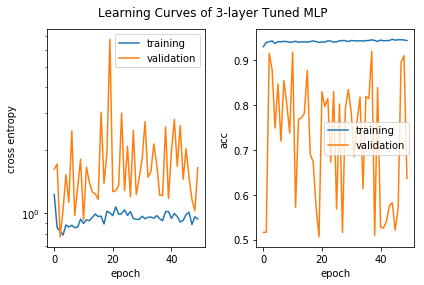

In [155]:
plot_history(model_tuned_mlp_history,'cross entropy','acc','Learning Curves of 3-layer Tuned MLP')

### Build CNN model for better classification performance

In [6]:
# build CNN models with desired hyperparameters and layers
def create_cnn(our_layers, 
                     optimizer='adam', lr=1e-3, 
                     output_dim=2,
                     conv_kernel=3, padding='valid',
                      pooling_kernel=2,
                      hidden_activation='relu',output_activation='softmax',
                      loss_fn='categorical_crossentropy',metrics=['accuracy']):
    '''  input: 
          our_layers: a list of string to represent the layer we create inside the CNN model '''
    # a sign whether we have created a fc layer alreadt
    if_fc=0
    model = Sequential()
    # reshape for convolution operation
    model.add(Reshape((25,25,3), input_shape=(25,25,3)))
    #model.add(Reshape((25,28,1), input_shape=(784,)))
    for temp_layer in our_layers[0:]:
        if temp_layer[0]=='c':
            # if the string starts with 'c', then it's a convolution layer, the channel number is the digit after 'c'
            temp_channel=int(temp_layer[1:])
            model.add(Conv2D(temp_channel,kernel_size=(conv_kernel, conv_kernel), activation=hidden_activation,padding=padding))
        if temp_layer[0]=='m':
            # if the string starts with 'm', then it's a max pooling layer
            model.add(MaxPooling2D(pool_size=(pooling_kernel, pooling_kernel)))
        if temp_layer[0]=='d':
            # if the string starts with 'd', then it's a dropout, the probability is the number after 'd'
            prob=float(temp_layer[1:])
            model.add(Dropout(prob))
        if temp_layer[:2]=='bn':
            # if the string starts with 'bn', then it's batch normalization
            model.add(BatchNormalization())
        if temp_layer[:2]=='fc':
            # if the string starts with 'fc', then it's a fc layer, the neuron number is the digit after 'fc'
            temp_dim=int(temp_layer[2:])
            # if we have not created fc yet, we need to flatten the layer for fc operation.
            if if_fc==0:
                model.add(Flatten())
            model.add(Dense(temp_dim, activation = hidden_activation))
            if_fc=1
    model.add(Dense(output_dim, activation = output_activation))
    model.compile(loss = loss_fn, optimizer = optimizer, metrics = metrics)
    model.optimizer.lr=lr
    #model.summary()
    return model
    

In [158]:
# build naive layer with Conv layer and FC layer only
naive_cnn_layer=['c16','c32','m','c64','c64','m','fc128','fc64']
model_naive_cnn=create_cnn(naive_cnn_layer)
model_naive_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 25, 25, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
__________

In [161]:
model_naive_cnn_history = model_naive_cnn.fit(x_train, y_train,
                                            batch_size=128,
                                            epochs=50,
                                            validation_data = (x_val, y_val),
                                            )

Train on 30947 samples, validate on 6073 samples
Epoch 1/50
30947/30947 [==============================] - 28s 907us/step - loss: 1.0479 - acc: 0.8767 - val_loss: 0.1437 - val_acc: 0.9519
Epoch 2/50
30947/30947 [==============================] - 28s 914us/step - loss: 0.1338 - acc: 0.9555 - val_loss: 0.1173 - val_acc: 0.9588
Epoch 3/50
30947/30947 [==============================] - 31s 986us/step - loss: 0.1197 - acc: 0.9595 - val_loss: 0.1090 - val_acc: 0.9633
Epoch 4/50
30947/30947 [==============================] - 30s 954us/step - loss: 0.1079 - acc: 0.9637 - val_loss: 0.1074 - val_acc: 0.9639
Epoch 5/50
30947/30947 [==============================] - 31s 1ms/step - loss: 0.0986 - acc: 0.9665 - val_loss: 0.1033 - val_acc: 0.9643
Epoch 6/50
30947/30947 [==============================] - 31s 992us/step - loss: 0.0889 - acc: 0.9691 - val_loss: 0.1062 - val_acc: 0.9656
Epoch 7/50
30947/30947 [==============================] - 30s 972us/step - loss: 0.0851 - acc: 0.9714 - val_loss: 0.123

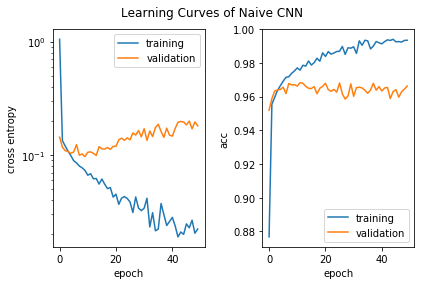

In [162]:
plot_history(model_naive_cnn_history,'cross entropy','acc','Learning Curves of Naive CNN')

In [163]:
# build tuned CNN model by adding tricks like dropout and batch normalization
tuned_cnn_layer=['c16','bn','c32','m','d0.3','bn','c64','c64','m','d0.3','bn','fc128','fc64']
model_tuned_cnn=create_cnn(tuned_cnn_layer)
model_tuned_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 25, 25, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 23, 23, 16)        448       
_________________________________________________________________
batch_normalization_9 (Batch (None, 23, 23, 16)        64        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 10, 10, 32)        128       
__________

In [164]:
model_tuned_cnn_history = model_tuned_cnn.fit(x_train, y_train,
                                            batch_size=128,
                                            epochs=50,
                                            validation_data = (x_val, y_val),
                                            )

Train on 30947 samples, validate on 6073 samples
Epoch 1/50
30947/30947 [==============================] - 54s 2ms/step - loss: 0.1739 - acc: 0.9380 - val_loss: 0.2429 - val_acc: 0.9065
Epoch 2/50
30947/30947 [==============================] - 52s 2ms/step - loss: 0.1199 - acc: 0.9572 - val_loss: 0.2103 - val_acc: 0.9391
Epoch 3/50
30947/30947 [==============================] - 52s 2ms/step - loss: 0.1048 - acc: 0.9624 - val_loss: 0.1213 - val_acc: 0.9557
Epoch 4/50
30947/30947 [==============================] - 51s 2ms/step - loss: 0.0974 - acc: 0.9645 - val_loss: 0.1018 - val_acc: 0.9638
Epoch 5/50
30947/30947 [==============================] - 52s 2ms/step - loss: 0.0904 - acc: 0.9672 - val_loss: 0.0992 - val_acc: 0.9639
Epoch 6/50
30947/30947 [==============================] - 52s 2ms/step - loss: 0.0901 - acc: 0.9672 - val_loss: 0.1042 - val_acc: 0.9600
Epoch 7/50
30947/30947 [==============================] - 51s 2ms/step - loss: 0.0859 - acc: 0.9687 - val_loss: 0.0797 - val_acc:

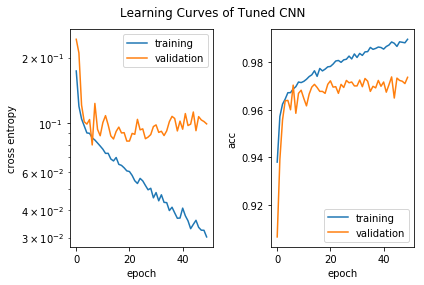

In [166]:
plot_history(model_tuned_cnn_history,'cross entropy','acc','Learning Curves of Tuned CNN')

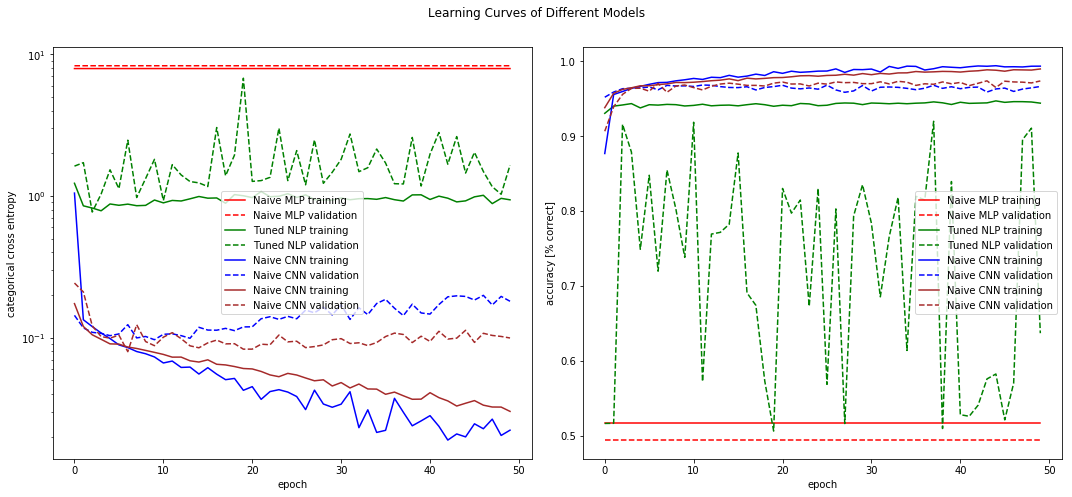

In [170]:
plot_different_histories(model_naive_mlp_history, model_tuned_mlp_history,model_naive_cnn_history, model_tuned_cnn_history,
                         label_1='Naive MLP',label_2='Tuned NLP',label_3='Naive CNN', label_4='Tuned CNN',
                         title='Learning Curves of Different Models')

It should be noted that the x_train, y_train, x_val, y_val used above is not data used for final training. They're only a small part of final training data, which contain 300,000 images and labels. This part is to choose the best model based on small part of data.

### We can see the tuned CNN model is the best among 4, with best accuracy and least overfitting phenomenon 

In [144]:
# save currently best model, used for later transfer learning on all images
model_tuned_cnn.save_weights('best_model.h5')

## 3.1.3 Train best CNN model on whole dataset

In [7]:
# create best CNN model above
best_layer=['c16','bn','c32','m','d0.3','bn','c64','c64','m','d0.3','bn','fc128','fc64']
best_model=create_cnn(best_layer)
best_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 25, 25, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 23, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 32)        128       
__________

In [8]:
# load the weights of pretrained model, that has been trained on only 10% of dataset
best_model.load_weights("best_model.h5")

In [137]:
# add early stopping for more rapid and efficient training
from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping (monitor='val_acc', min_delta=0.001, patience=5)
best_model_history = best_model.fit(x_train, y_train,
                                            batch_size=256,
                                            epochs=50,
                                            validation_data = (x_val, y_val),
                                            callbacks=[early_stopping]
                                            )

Train on 222445 samples, validate on 42117 samples
Epoch 1/50
222445/222445 [==============================] - 371s 2ms/step - loss: 0.0593 - acc: 0.9775 - val_loss: 0.0426 - val_acc: 0.9854
Epoch 2/50
222445/222445 [==============================] - 369s 2ms/step - loss: 0.0410 - acc: 0.9849 - val_loss: 0.0394 - val_acc: 0.9867
Epoch 3/50
222445/222445 [==============================] - 369s 2ms/step - loss: 0.0366 - acc: 0.9867 - val_loss: 0.0335 - val_acc: 0.9875
Epoch 4/50
222445/222445 [==============================] - 368s 2ms/step - loss: 0.0341 - acc: 0.9875 - val_loss: 0.0352 - val_acc: 0.9880
Epoch 5/50
222445/222445 [==============================] - 373s 2ms/step - loss: 0.0320 - acc: 0.9884 - val_loss: 0.0347 - val_acc: 0.9880
Epoch 6/50
222445/222445 [==============================] - 368s 2ms/step - loss: 0.0300 - acc: 0.9891 - val_loss: 0.0392 - val_acc: 0.9849
Epoch 7/50
222445/222445 [==============================] - 369s 2ms/step - loss: 0.0286 - acc: 0.9894 - val_

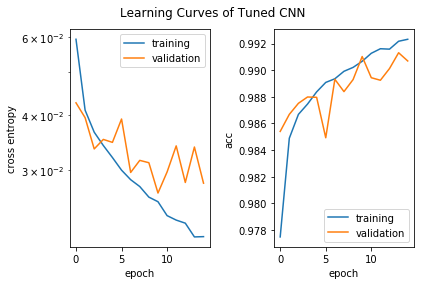

In [143]:
plot_history(best_model_history,'cross entropy','acc','Learning Curves of Tuned CNN')

It shows that the prediction accuracy on validation set is about 99%, which means the CNN model is sufficient for the sliding window classification. The major imrpovement in the method can be achieved by optimization of how to get the proper and large amounts of sliding windows.

In [172]:
# save the model weights
best_model.save_weights('best_model.h5')

In [173]:
best_model=create_cnn(tuned_cnn_layer)
best_model.load_weights("best_model.h5")

## 3.1.4 Use the trained model to predict the bbox on test images 

In [7]:
# load testing data
test_name,test_image,test_bbox=get_dataset(50,data_type='test')

In [10]:
# iteratively crop each test image with 25*25*3 sliding window
# return each potential bounding box corrdinated and corresponding 25*25*3 image on each test image
# form of output: [x1, y1,weight,height], [array of 25*25*3 image]
def crop_image_by_sliding_window(image,size=25):
    bbox_image_list=[]
    width=image.shape[0]
    height=image.shape[1]
    for temp_width in range(0,width,size):
        for temp_height in range(0,height,size):
            temp_bbox=[temp_width,temp_height,size,size]
            temp_image=image[temp_height:temp_height+size,temp_width:temp_width+size,:]
            bbox_image_list=bbox_image_list+[[temp_bbox,temp_image]]
    return bbox_image_list

In [11]:
# predict the label of each 25*5*3 image of a single full test image by trained CNN model
# label 1 means varroa, label 0 means non-varroa
# return the list of bbox with label 1 for each test image

def predict_one_image_by_cnn(image):
    pred_bbox_list=[]
    bbox_image_list=crop_image_by_sliding_window(image)
    for temp_bbox_image in bbox_image_list:
        temp_bbox=temp_bbox_image[0]
        temp_image=temp_bbox_image[1]
        
        try:
            temp_image=temp_image.reshape(1,25,25,3)
            temp_pred=best_model.predict_classes(temp_image)[0]
            #print(temp_pred)
        
            if temp_pred:
                pred_bbox_list=pred_bbox_list+[temp_bbox]
        except:
            continue
    return pred_bbox_list

In [17]:
def plot_gt_bbox(bbox,ax):
    for temp_bbox in bbox:
        rect = patches.Rectangle((temp_bbox['bbox'][0], temp_bbox['bbox'][1]), temp_bbox['bbox'][2], temp_bbox['bbox'][3],
                linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
def plot_pred_bbox(bbox,ax):
    for temp_bbox in bbox:
        rect = patches.Rectangle((temp_bbox[0], temp_bbox[1]), temp_bbox[2], temp_bbox[3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    

In [18]:
# predict bbox on 1st test image
predict_one_image_by_cnn(test_image[test_name[0]])

[]

Text(0.5,1,'Prediction')

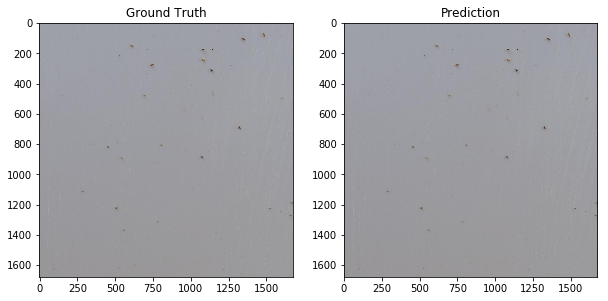

In [19]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (10 ,6))
ax1.imshow(test_image[test_name[0]])
plot_gt_bbox(test_bbox[test_name[0]],ax1)
ax1.set_title('Ground Truth')
ax2.imshow(test_image[test_name[0]])
plot_pred_bbox(predict_one_image_by_cnn(test_image[test_name[0]]),ax2)
ax2.set_title('Prediction')

In [20]:
# predict bbox on 2nd test image
predict_one_image_by_cnn(test_image[test_name[2]])

[[0, 450, 25, 25],
 [25, 450, 25, 25],
 [25, 1325, 25, 25],
 [50, 75, 25, 25],
 [50, 225, 25, 25],
 [175, 475, 25, 25],
 [225, 950, 25, 25],
 [350, 775, 25, 25],
 [375, 600, 25, 25],
 [425, 325, 25, 25],
 [425, 450, 25, 25],
 [450, 375, 25, 25],
 [450, 450, 25, 25],
 [475, 1250, 25, 25],
 [600, 550, 25, 25],
 [600, 800, 25, 25],
 [625, 0, 25, 25],
 [625, 550, 25, 25],
 [650, 200, 25, 25],
 [1025, 375, 25, 25],
 [1050, 0, 25, 25],
 [1125, 550, 25, 25],
 [1175, 550, 25, 25],
 [1200, 550, 25, 25],
 [1250, 225, 25, 25],
 [1425, 500, 25, 25],
 [1550, 175, 25, 25]]

Text(0.5,1,'Prediction')

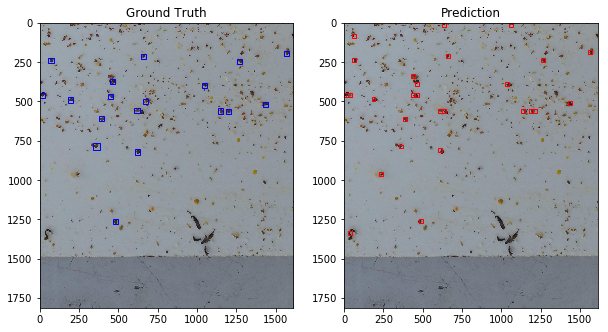

In [21]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (10 ,6))
ax1.imshow(test_image[test_name[2]])
plot_gt_bbox(test_bbox[test_name[2]],ax1)
ax1.set_title('Ground Truth')
ax2.imshow(test_image[test_name[2]])
plot_pred_bbox(predict_one_image_by_cnn(test_image[test_name[2]]),ax2)
ax2.set_title('Prediction')

We can see the segmentation performance by CNN model is quite acceptable.

Below we will predict on all images in test.

In [235]:
# predict bbox of each test image on all testing images
# return the desied dictionary format for later json processing
def predict_all_images_by_cnn(names, images):
    final_dict={}
    for temp_name in names:
        temp_image=images[temp_name]
        # predict bbox on each image
        pred_bbox=predict_one_image_by_cnn(temp_image)
        # use a dictionary to correspond image name id with predicted bboxes
        final_dict[temp_name]=pred_bbox
    return final_dict

In [237]:
test_pred=predict_all_images_by_cnn(test_name,test_image)

In [146]:
# save predicted dictionary for all test images
import pickle
with open("test_prediction.pkl", "wb") as file:
    pickle.dump(test_pred, file)

In [239]:
import numpy as np
import json

def generate_pred_json(data, tag='test_pred'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [240]:
# generate json for submitting online to verify
generate_pred_json(test_pred)

58ea4f69579e520dd055b3db_32.00px_6
58e7c5e3579e52085efb48f4_32.00px_2
58e7db24579e520d2470641c_32.00px_4
5991982d579e52a0e6c05e47_32.00px_4
59a2f0d8a07d5673ec099c8a_32.00px_9
5a0de18fa07d56baef59b1f8_32.00px_19
5c003119a07d5676543eb99d_32.00px_19
59ef06a3a07d563535ffc6c9_32.00px_13
5a4a00c8a07d567e7d04bed6_32.00px_2
59f01ac3a07d563535ffc6d1_32.00px_15
5a3eadcea07d567e7d04beb2_32.00px_3
5a469c95a07d567e7d04bec7_32.00px_5
5903312b579e52581ddedea8_32.00px_11
5a3a7fdaa07d567e7d04be86_32.00px_4
59a5c0c3a07d565d45b82dc4_32.00px_0
59cd4750a07d562888f854fd_32.00px_2
599c489b579e52a0e6c05e5c_32.00px_1
599a969f579e52a0e6c05e4f_32.00px_3
599ad824579e52a0e6c05e5b_32.00px_8
599a9c3e579e52a0e6c05e51_32.00px_4
5a4407aba07d567e7d04bec3_32.00px_11
5a3a6f77a07d567e7d04be77_32.00px_2
5a469e2ca07d567e7d04bec9_32.00px_2
5a19d440a07d5643ecfab27c_32.00px_8
5a1b1b02a07d5643ecfab28a_32.00px_18
599a969f579e52a0e6c05e4f_32.00px_1
5bf9855da07d568353ddcf22_32.00px_18
599f14e8a07d5673ec099c83_32.00px_14
59023fbd579

### According to the result, the predcition on 50 testing images have a F1 score of 0.43 with threshold 0.1 and 0.39 with threshold 0.3.

### We also calculate the metrics by defined function

In [7]:
test_name,test_image,test_bbox=get_dataset(50,data_type='test')

In [8]:
with open("test_prediction.pkl", "rb") as file:
    test_pred = pickle.load(file)

In [9]:
f1_list = []
prec_list = []
rec_list = []
for temp_name in test_name:
    temp_pred_bboxes=test_pred[temp_name]
    temp_gt_bboxes=[]
    for temp_gt_bbox in test_bbox[temp_name]:
        temp_bbox=temp_gt_bbox['bbox']
        temp_gt_bboxes.append(temp_bbox)
    #print(temp_gt_bboxes)
    if len(temp_gt_bboxes)!=0:
        try:
            iou_scores = [np.max([IoU(bbox_1, bbox_2) for bbox_1 in temp_gt_bboxes]) for bbox_2 in temp_pred_bboxes]
            prec, rec, f1 = cal_stats(iou_scores, thrs = 0.3, gtl = len(temp_gt_bboxes))
            #print(rec)
            if f1>=0 and f1<=1:
                f1_list.append(f1)
            if prec>=0 and prec<=1:
                prec_list.append(prec)
            if rec>=0 and rec<=1:
                rec_list.append(rec)
        except:
            pass
avg_prec=np.mean(np.array(prec_list))
avg_rec=np.mean(np.array(rec_list))
avg_f1=np.mean(np.array(f1_list))
print('Average precision of predicted bounding boxes with threshold 0.3 by CNN is '+str(avg_prec))
print('Average recall of predicted bounding boxes with threshold 0.3 by CNN is '+str(avg_rec))
print('Average f1 score of predicted bounding boxes with threshold 0.3 by CNN is '+str(avg_f1))

Average precision of predicted bounding boxes with threshold 0.3 by CNN is 0.30084095336600686
Average recall of predicted bounding boxes with threshold 0.3 by CNN is 0.5957411661597258
Average f1 score of predicted bounding boxes with threshold 0.3 by CNN is 0.3792980336065715


# 3.2 Binary Sermantic Segmentation

## 3.2.1 Create training data for sermantic segmentation

In [4]:
train_name,train_image_0,train_bbox_0=get_dataset(300,data_type='train')
test_name,test_image_0,test_bbox_0=get_dataset(50,data_type='test')

In [5]:
# resize each image and recalculate corresponding coordinates of bboxes
def resize_image(train_name,train_image_0,train_bbox_0,size=400):
    train_image=train_image_0.copy()
    train_bbox=train_bbox_0.copy()
    for temp_name in train_name:
        temp_image=train_image[temp_name]
        new_image=cv2.resize(temp_image, (size,size))
        train_image[temp_name]=new_image
        temp_bboxes=train_bbox[temp_name]
        for i in range(len(temp_bboxes)):
            temp_cordinates=np.array(temp_bboxes[i]['bbox'])
            temp_cordinates[0]=temp_cordinates[0]*size/temp_image.shape[0]
            temp_cordinates[2]=temp_cordinates[2]*size/temp_image.shape[0]
            temp_cordinates[1]=temp_cordinates[1]*size/temp_image.shape[1]
            temp_cordinates[3]=temp_cordinates[3]*size/temp_image.shape[1]
            train_bbox[temp_name][i]['bbox']=temp_cordinates
    return train_name,train_image,train_bbox

In [6]:
train_name,train_image,train_bbox=resize_image(train_name,train_image_0,train_bbox_0,size=400)
test_name,test_image,test_bbox=resize_image(test_name,test_image_0,test_bbox_0,size=400)

In [7]:
# create corresponding binary image with same size for each training image
# in the processed binary image label
# pixel value=1 for the pixels in a bounding box
# pixel value=0 for non-bbox pixels
def create_sermantic_label(train_name,train_image_0,train_bbox_0,size=400):
    train_image=train_image_0.copy()
    train_bbox=train_bbox_0.copy()
    for temp_name in train_name:
        temp_image=np.zeros((size,size))
        for temp_bboxes in train_bbox[temp_name]:
            temp_bbox=temp_bboxes['bbox']
            xmin=int(temp_bbox[0])
            ymin=int(temp_bbox[1])
            dx=int(temp_bbox[2])
            dy=int(temp_bbox[3])
            for i in range(dx):
                for j in range(dy):
                    try:
                        temp_image[ymin+j][xmin+i]=1
                    except:
                        continue
        train_image[temp_name]=temp_image
    return train_image

In [8]:
train_semantic_label=create_sermantic_label(train_name,train_image_0,train_bbox_0,size=400)
test_semantic_label=create_sermantic_label(test_name,test_image_0,test_bbox_0,size=400)

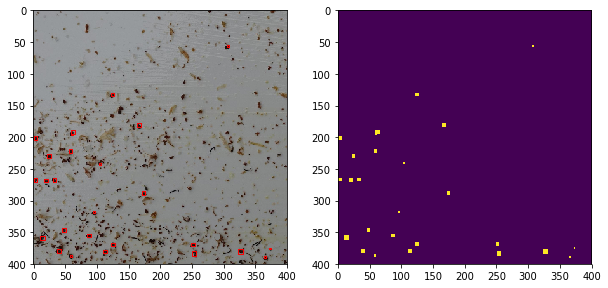

In [9]:
def plot_bbox(bbox,ax):
    for temp_bbox in bbox:
        rect = patches.Rectangle((temp_bbox['bbox'][0], temp_bbox['bbox'][1]), temp_bbox['bbox'][2], temp_bbox['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (10 ,6))
ax1.imshow(train_image[train_name[1]])
plot_bbox(train_bbox[train_name[1]],ax1)
ax2.imshow(train_semantic_label[train_name[1]])

So far, we have create the image and binary image label for sermantic segmentation.

## 3.2.2 Build U-net

To try to avoid the influence of biased label, we first make some efforts to change the metric and loss used for training.

In [10]:
# we use f1 score metric and dice loss to try to improve the training
import keras.backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [11]:
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, Activation, MaxPooling2D, Dropout, BatchNormalization
from keras.layers import add, concatenate
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard

In [12]:
# build a U-Net model
def conv2d_block(inputs, n_filter, kernel_size=3, batchnorm=True, activation='relu'):
    # first layer
    x = Conv2D(n_filter, kernel_size=kernel_size, kernel_initializer="he_normal",
               padding="same")(inputs)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    # second layer
    x = Conv2D(n_filter, kernel_size=kernel_size, kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x


def unet(pretrained_weights = None,
         input_size = (400,400,3),
         n_filter=16,
         activation='relu',
         dropout=True, dropout_rate=0.5,
         batchnorm=True,
         loss=binary_crossentropy,
         optimizer=Adam(lr=1e-4)):
    """Build a standard UNet model.

    Arguments:
        pretrained_weights {str} -- path of the pretrained weights (default: {None})
        input_size {tuple} -- size of input images (default: {(None,None,3)})
        n_filter {int} -- number of filter of the first layer (default: {16})
        activation {str} -- activation function to use (default: {'relu'})
        dropout {bool} -- whether to use dropout layer (default: {True})
        dropout_rate {float} -- dropout rate (default: {0.5})
        batchnorm {bool} -- whether to use batch normalization layer (default: {True})
        loss {keras.losses} -- loss function to use (default: {binary_crossentropy})
        optimizer {keras.optimizers} -- optimizer to use (default: {Adam(lr=1e-4)})
    Returns:
        keras.models -- UNet model

    """
    # 3
    inputs = Input(input_size)
    # down path
    # n_filter
    conv1 = conv2d_block(inputs, n_filter, kernel_size=3, batchnorm=batchnorm, activation=activation)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # n_filter*2
    conv2 = conv2d_block(pool1, n_filter*2, kernel_size=3, batchnorm=batchnorm, activation=activation)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # n_filter*4
    conv3 = conv2d_block(pool2, n_filter*4, kernel_size=3, batchnorm=batchnorm, activation=activation)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # n_filter*8
    conv4 = conv2d_block(pool3, n_filter*8, kernel_size=3, batchnorm=batchnorm, activation=activation)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # central path
    # n_filter*16
    conv5 = conv2d_block(pool4, n_filter*16, kernel_size=3, batchnorm=batchnorm, activation=activation)
    # up path
    # n_filter*8
    up6 = Conv2DTranspose(n_filter*8, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(conv5)
    merge6 = concatenate([conv4, up6], axis = 3)
    merge6 = Dropout(dropout_rate)(merge6) if dropout else merge6
    conv6 = conv2d_block(merge6, n_filter*8, kernel_size=3, batchnorm=False, activation=activation) 
    # n_filter*4
    up7 = Conv2DTranspose(n_filter*4, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis = 3)
    merge7 = Dropout(dropout_rate)(merge7) if dropout else merge7
    conv7 = conv2d_block(merge7, n_filter*4, kernel_size=3, batchnorm=False, activation=activation)
    # n_filter*2
    up8 = Conv2DTranspose(n_filter*2, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis = 3)
    merge8 = Dropout(dropout_rate)(merge8) if dropout else merge8
    conv8 = conv2d_block(merge8, n_filter*2, kernel_size=3, batchnorm=False, activation=activation)
    # n_filter
    up9 = Conv2DTranspose(n_filter, kernel_size=2, strides=2, kernel_initializer="he_normal", padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis = 3)
    merge9 = Dropout(dropout_rate)(merge9) if dropout else merge9
    conv9 = conv2d_block(merge9, n_filter, kernel_size=3, batchnorm=False, activation=activation) 
    # classifier
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = optimizer, loss = loss, metrics = [f1, 'accuracy'])   

    if(pretrained_weights):
        model.load_weights(filepath=pretrained_weights)
    return model

In [13]:
model_32 = unet(n_filter=32, activation='elu', dropout_rate=0.2, loss=dice_loss)
callbacks = [
    # EarlyStopping(monitor='val_loss', patience=9, verbose=1, min_delta=1e-4),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-4),
    ModelCheckpoint('weights_32.h5', monitor='val_loss', save_best_only=True, verbose=1)
]
model_32.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 400, 400, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 400, 400, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

## 3.2.3 Training U-Net

In [14]:
def get_nn_dataset(name,image,label):
    x=[]
    y=[]
    for temp_name in name:
        temp_image=image[temp_name]
        x=x+[temp_image]
        temp_label=label[temp_name]
        y=y+[temp_label]
    x=np.array(x)/255
    y=np.array(y)
    return x,y

In [15]:
# get training data
x_train,y_train=get_nn_dataset(train_name,train_image,train_semantic_label)
y_train=y_train.reshape(300,400,400,1)
x_test,y_test=get_nn_dataset(test_name,test_image,test_semantic_label)
y_test=y_test.reshape(50,400,400,1)

In [16]:
history_unet = model_unet.fit(x_train, y_train,
                            batch_size=10,
                            epochs=10,
                            validation_data = (x_test, y_test),
                         )
                            #verbose=1)
                            #callbacks=callbacks)

Train on 300 samples, validate on 50 samples
Epoch 1/10
300/300 [==============================] - 1688s 6s/step - loss: 0.9932 - f1: 0.0070 - acc: 0.5467 - val_loss: 0.9880 - val_f1: 0.0132 - val_acc: 0.9800
Epoch 2/10
300/300 [==============================] - 1660s 6s/step - loss: 0.9817 - f1: 0.0201 - acc: 0.9544 - val_loss: 0.9838 - val_f1: 0.0155 - val_acc: 0.9913
Epoch 3/10
300/300 [==============================] - 1640s 5s/step - loss: 0.9692 - f1: 0.0323 - acc: 0.9932 - val_loss: 0.9574 - val_f1: 0.0449 - val_acc: 0.9931
Epoch 4/10
300/300 [==============================] - 1639s 5s/step - loss: 0.9395 - f1: 0.0623 - acc: 0.9963 - val_loss: 0.9809 - val_f1: 0.0187 - val_acc: 0.9968
Epoch 5/10
300/300 [==============================] - 1628s 5s/step - loss: 0.9436 - f1: 0.0568 - acc: 0.9953 - val_loss: 0.9482 - val_f1: 0.0528 - val_acc: 0.9920
Epoch 6/10
300/300 [==============================] - 1636s 5s/step - loss: 0.9338 - f1: 0.0668 - acc: 0.9964 - val_loss: 0.9260 - val_

In [17]:
model_unet.save("Unet_model")

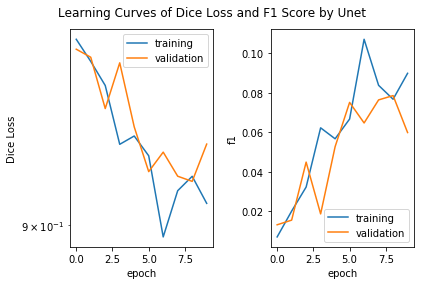

In [22]:
plot_history(history_unet,'Dice Loss','f1','Learning Curves of Dice Loss and F1 Score by Unet')

We can see that the training of U-net in this task is rather time-consuming, and 10 epochs will spend several hours. We do not have enough time to train a full net like this although the total F1 score is increasing slowly. Besides, more precise hyperparameter tuning and efforts to reduce the influence of biased sermantic label are required in future work.

### We try to treat the problem in 2 ways by neural network, classification by sliding window and sermantic segmentation. So far, the first method seems to be a better solution in our case, we will predict the bbox of the competition challenge by this method.

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

### According to the result, our method achieve the best F1 score of 0.46 on competition dataset.

In [150]:
# load competition dataset
# with image name id and image
def get_competition_dataset():
    data_dir = 'project-data/'
    with open(data_dir+'competition'+'.txt', 'r') as f:
        filenames = f.read().split('\n')
        
    # Get images
    images = skimage.io.imread_collection([data_dir+'images/'+'competition'+'/'+img_name+'.jpg'
                                                      for img_name in filenames])
    
  
    image_dict={}
    for i in range(259):
        temp_name=filenames[i]
        temp_image=images[i]

        image_dict[temp_name]=temp_image
    return filenames,image_dict

In [151]:
comp_name,comp_image=get_competition_dataset()

In [152]:
# predict the bounding box by CNN and sliding window
comp_pred=predict_all_images_by_cnn(comp_name,comp_image)

In [153]:
import numpy as np
import json

def generate_pred_json(data, tag='comp_1'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [154]:
# generate json for submitting challenge
generate_pred_json(comp_pred)

5902310d579e52581ddede9e_32.00px_1
5a3d53aea07d567e7d04bea6_32.00px_3
5a19ca0ba07d5643ecfab278_32.00px_0
5a0340b2a07d56baef59b1a2_32.00px_12
5a4698f6a07d567e7d04bec4_32.00px_8
5a08c1dca07d56baef59b1d7_32.00px_7
5a02bb74a07d56e705f896a6_32.00px_5
5a3431e0a07d567f57e0272c_32.00px_1
5a4698f6a07d567e7d04bec4_32.00px_4
5a056f88a07d56baef59b1ad_32.00px_8
5a19ca0ba07d5643ecfab278_32.00px_3
5a08c1dca07d56baef59b1d7_32.00px_11
5a4698f6a07d567e7d04bec4_32.00px_7
5b18d93da07d5605be933de1_32.00px_6
5b18d93da07d5605be933de1_32.00px_4
5a0340b2a07d56baef59b1a2_32.00px_18
599ab164579e52a0e6c05e54_32.00px_5
59f0a549a07d563535ffc6d6_32.00px_0
5a1e4ac3a07d5643ecfab295_32.00px_4
598a0f0f579e528819ade1f0_32.00px_3
5a0340b2a07d56baef59b1a2_32.00px_13
58ea52a5579e520dd055b3dc_32.00px_3
5902310d579e52581ddede9e_32.00px_11
5a08c1dca07d56baef59b1d7_32.00px_10
599ab164579e52a0e6c05e54_32.00px_2
5a4698f6a07d567e7d04bec4_32.00px_1
5902310d579e52581ddede9e_32.00px_4
598a0c77579e528819ade1ef_32.00px_3
59a70420a07d56